In [1]:
import cv2
import numpy as np
from collections import defaultdict

# ===================== CONFIGURATION =====================
panoptic_path = "xxx_panoptic_seg.png"
category_overlay_path = "xxx_s07.png"

# ===================== READ IMAGES =====================
print("Reading images...")
pan = cv2.imread(panoptic_path, cv2.IMREAD_UNCHANGED)
cat = cv2.imread(category_overlay_path, cv2.IMREAD_COLOR)  # BGR

if pan is None or cat is None:
    raise FileNotFoundError("Unable to read input images. Please check the paths.")

# ===================== DECODE SEGMENT ID =====================
R = pan[:, :, 2].astype(np.uint32)
G = pan[:, :, 1].astype(np.uint32)
B = pan[:, :, 0].astype(np.uint32)
segment_ids = R * 256 * 256 + G * 256 + B
unique_ids = np.unique(segment_ids)
unique_ids = unique_ids[unique_ids != 0]
print(f"Detected total number of segments (thing+stuff): {len(unique_ids)}")

# ===================== DEFINE COLORS =====================
category_colors = {
    "seepage": np.array([195, 35, 65]),
    "corrosion": np.array([125, 40, 55]),
    "crack": np.array([130, 40, 220]),
    "spalling": np.array([20, 20, 200])
}
thing_names = list(category_colors.keys())
thing_color_array = np.stack([category_colors[n] for n in thing_names]).astype(np.float32)

# Stuff classes depend only on the R channel of the panoptic image
stuff_r_to_name = {
    5: "tunnel",
    6: "equipments",
    7: "signs",
    8: "repaired_part"
}

# ===================== RGB CONVERSION =====================
cat_rgb = cat[:, :, ::-1]  # BGR -> RGB

# ===================== INITIALIZE COUNTS =====================
counts = defaultdict(int)

# ===================== ITERATE THROUGH SEGMENTS =====================
for sid in unique_ids:
    # Recover R/G/B values for this sid
    r = (sid >> 16) & 255
    g = (sid >> 8) & 255
    b = sid & 255

    # ---- Check if it's a stuff class ----
    if g == 0 and b == 0 and (r in stuff_r_to_name):
        counts[stuff_r_to_name[r]] += 1
        continue

    # ---- Process thing classes ----
    mask = (segment_ids == sid)
    if np.count_nonzero(mask) < 10:
        continue  # Ignore tiny segments

    # Take median color (robust to text interference)
    pixels = cat_rgb[mask]  # (N,3)
    median_color = np.median(pixels, axis=0)

    # Compute nearest neighbor among category_colors
    distances = np.linalg.norm(thing_color_array - median_color, axis=1)
    assigned = thing_names[np.argmin(distances)]
    counts[assigned] += 1

# ===================== OUTPUT STATISTICS =====================
print("\n📊 Classification statistics:")
ordered = thing_names + list(stuff_r_to_name.values())
for name in ordered:
    print(f"  {name:<15}: {counts.get(name,0)}")

print("\n✅ Counting completed.")


Reading images...
Detected total number of segments (thing+stuff): 147

📊 Classification statistics:
  seepage        : 128
  corrosion      : 3
  crack          : 7
  spalling       : 5
  tunnel         : 1
  equipments     : 1
  signs          : 1
  repaired_part  : 1

✅ Counting completed.


In [2]:
import cv2
import numpy as np
import json
from collections import defaultdict

# ===================== CONFIGURATION =====================
panoptic_path = "xxx_panoptic_seg.png"
category_overlay_path = "xxx_s07.png"
output_json_path = "output_things_coco.json"

# ===================== READ IMAGES =====================
print("Reading images...")
pan = cv2.imread(panoptic_path, cv2.IMREAD_UNCHANGED)
cat = cv2.imread(category_overlay_path, cv2.IMREAD_COLOR)  # BGR

if pan is None or cat is None:
    raise FileNotFoundError("Unable to read input images. Please check the paths.")

# ===================== DECODE SEGMENT ID =====================
R = pan[:, :, 2].astype(np.uint32)
G = pan[:, :, 1].astype(np.uint32)
B = pan[:, :, 0].astype(np.uint32)
segment_ids = R * 256 * 256 + G * 256 + B
unique_ids = np.unique(segment_ids)
unique_ids = unique_ids[unique_ids != 0]
print(f"Detected total number of segments (thing+stuff): {len(unique_ids)}")

# ===================== DEFINE THING CATEGORIES =====================
category_colors = {
    "seepage": np.array([195, 35, 65]),
    "corrosion": np.array([125, 40, 55]),
    "crack": np.array([130, 40, 220]),
    "spalling": np.array([20, 20, 200])
}
thing_names = list(category_colors.keys())

# Assign COCO-style category IDs
category_id_map = {name: idx + 1 for idx, name in enumerate(thing_names)}
thing_color_array = np.stack([category_colors[n] for n in thing_names]).astype(np.float32)

# ===================== CONVERT RGB =====================
cat_rgb = cat[:, :, ::-1]  # BGR -> RGB

# ===================== INITIALIZE =====================
annotations = []
instance_id = 1
counts = defaultdict(int)
h, w = segment_ids.shape

# ===================== ITERATE THROUGH SEGMENTS =====================
for sid in unique_ids:
    # Recover R/G/B for this sid
    r = (sid >> 16) & 255
    g = (sid >> 8) & 255
    b = sid & 255

    # ---- Ignore stuff ----
    if g == 0 and b == 0 and r in [5, 6, 7, 8]:
        continue

    mask = (segment_ids == sid).astype(np.uint8)
    if cv2.countNonZero(mask) < 10:
        continue

    # ---- Match median color to thing categories ----
    ys, xs = np.where(mask)
    pixels = cat_rgb[ys, xs]
    median_color = np.median(pixels, axis=0)
    distances = np.linalg.norm(thing_color_array - median_color, axis=1)
    category_name = thing_names[np.argmin(distances)]
    category_id = category_id_map[category_name]
    counts[category_name] += 1

    # ---- Extract contours ----
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentations = []
    for c in contours:
        if len(c) < 3:
            continue
        c = c.squeeze(1).astype(float)
        if c.shape[0] >= 3:
            segmentations.append(c.ravel().tolist())
    if not segmentations:
        continue

    # ---- Compute bounding box and area ----
    x, y, w_box, h_box = cv2.boundingRect(mask)
    area = float(cv2.countNonZero(mask))

    annotations.append({
        "id": instance_id,
        "image_id": 1,
        "category_id": category_id,
        "bbox": [float(x), float(y), float(w_box), float(h_box)],
        "area": area,
        "segmentation": segmentations,
        "iscrowd": 0
    })
    instance_id += 1

# ===================== PRINT STATISTICS =====================
print(f"✅ Successfully generated COCO annotation instances: {len(annotations)}")
print("📊 Instance count by category:")
for name in thing_names:
    print(f"  {name:<15}: {counts.get(name, 0)}")

# ===================== GENERATE COCO JSON =====================
coco_output = {
    "images": [{
        "file_name": panoptic_path,
        "height": h,
        "width": w,
        "id": 1
    }],
    "annotations": annotations,
    "categories": [{"id": cid, "name": name} for name, cid in category_id_map.items()]
}

with open(output_json_path, "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"✅ COCO JSON file generated: {output_json_path}")


Reading images...
Detected total number of segments (thing+stuff): 147
✅ Successfully generated COCO annotation instances: 143
📊 Instance count by category:
  seepage        : 128
  corrosion      : 3
  crack          : 7
  spalling       : 5
✅ COCO JSON file generated: output_things_coco.json


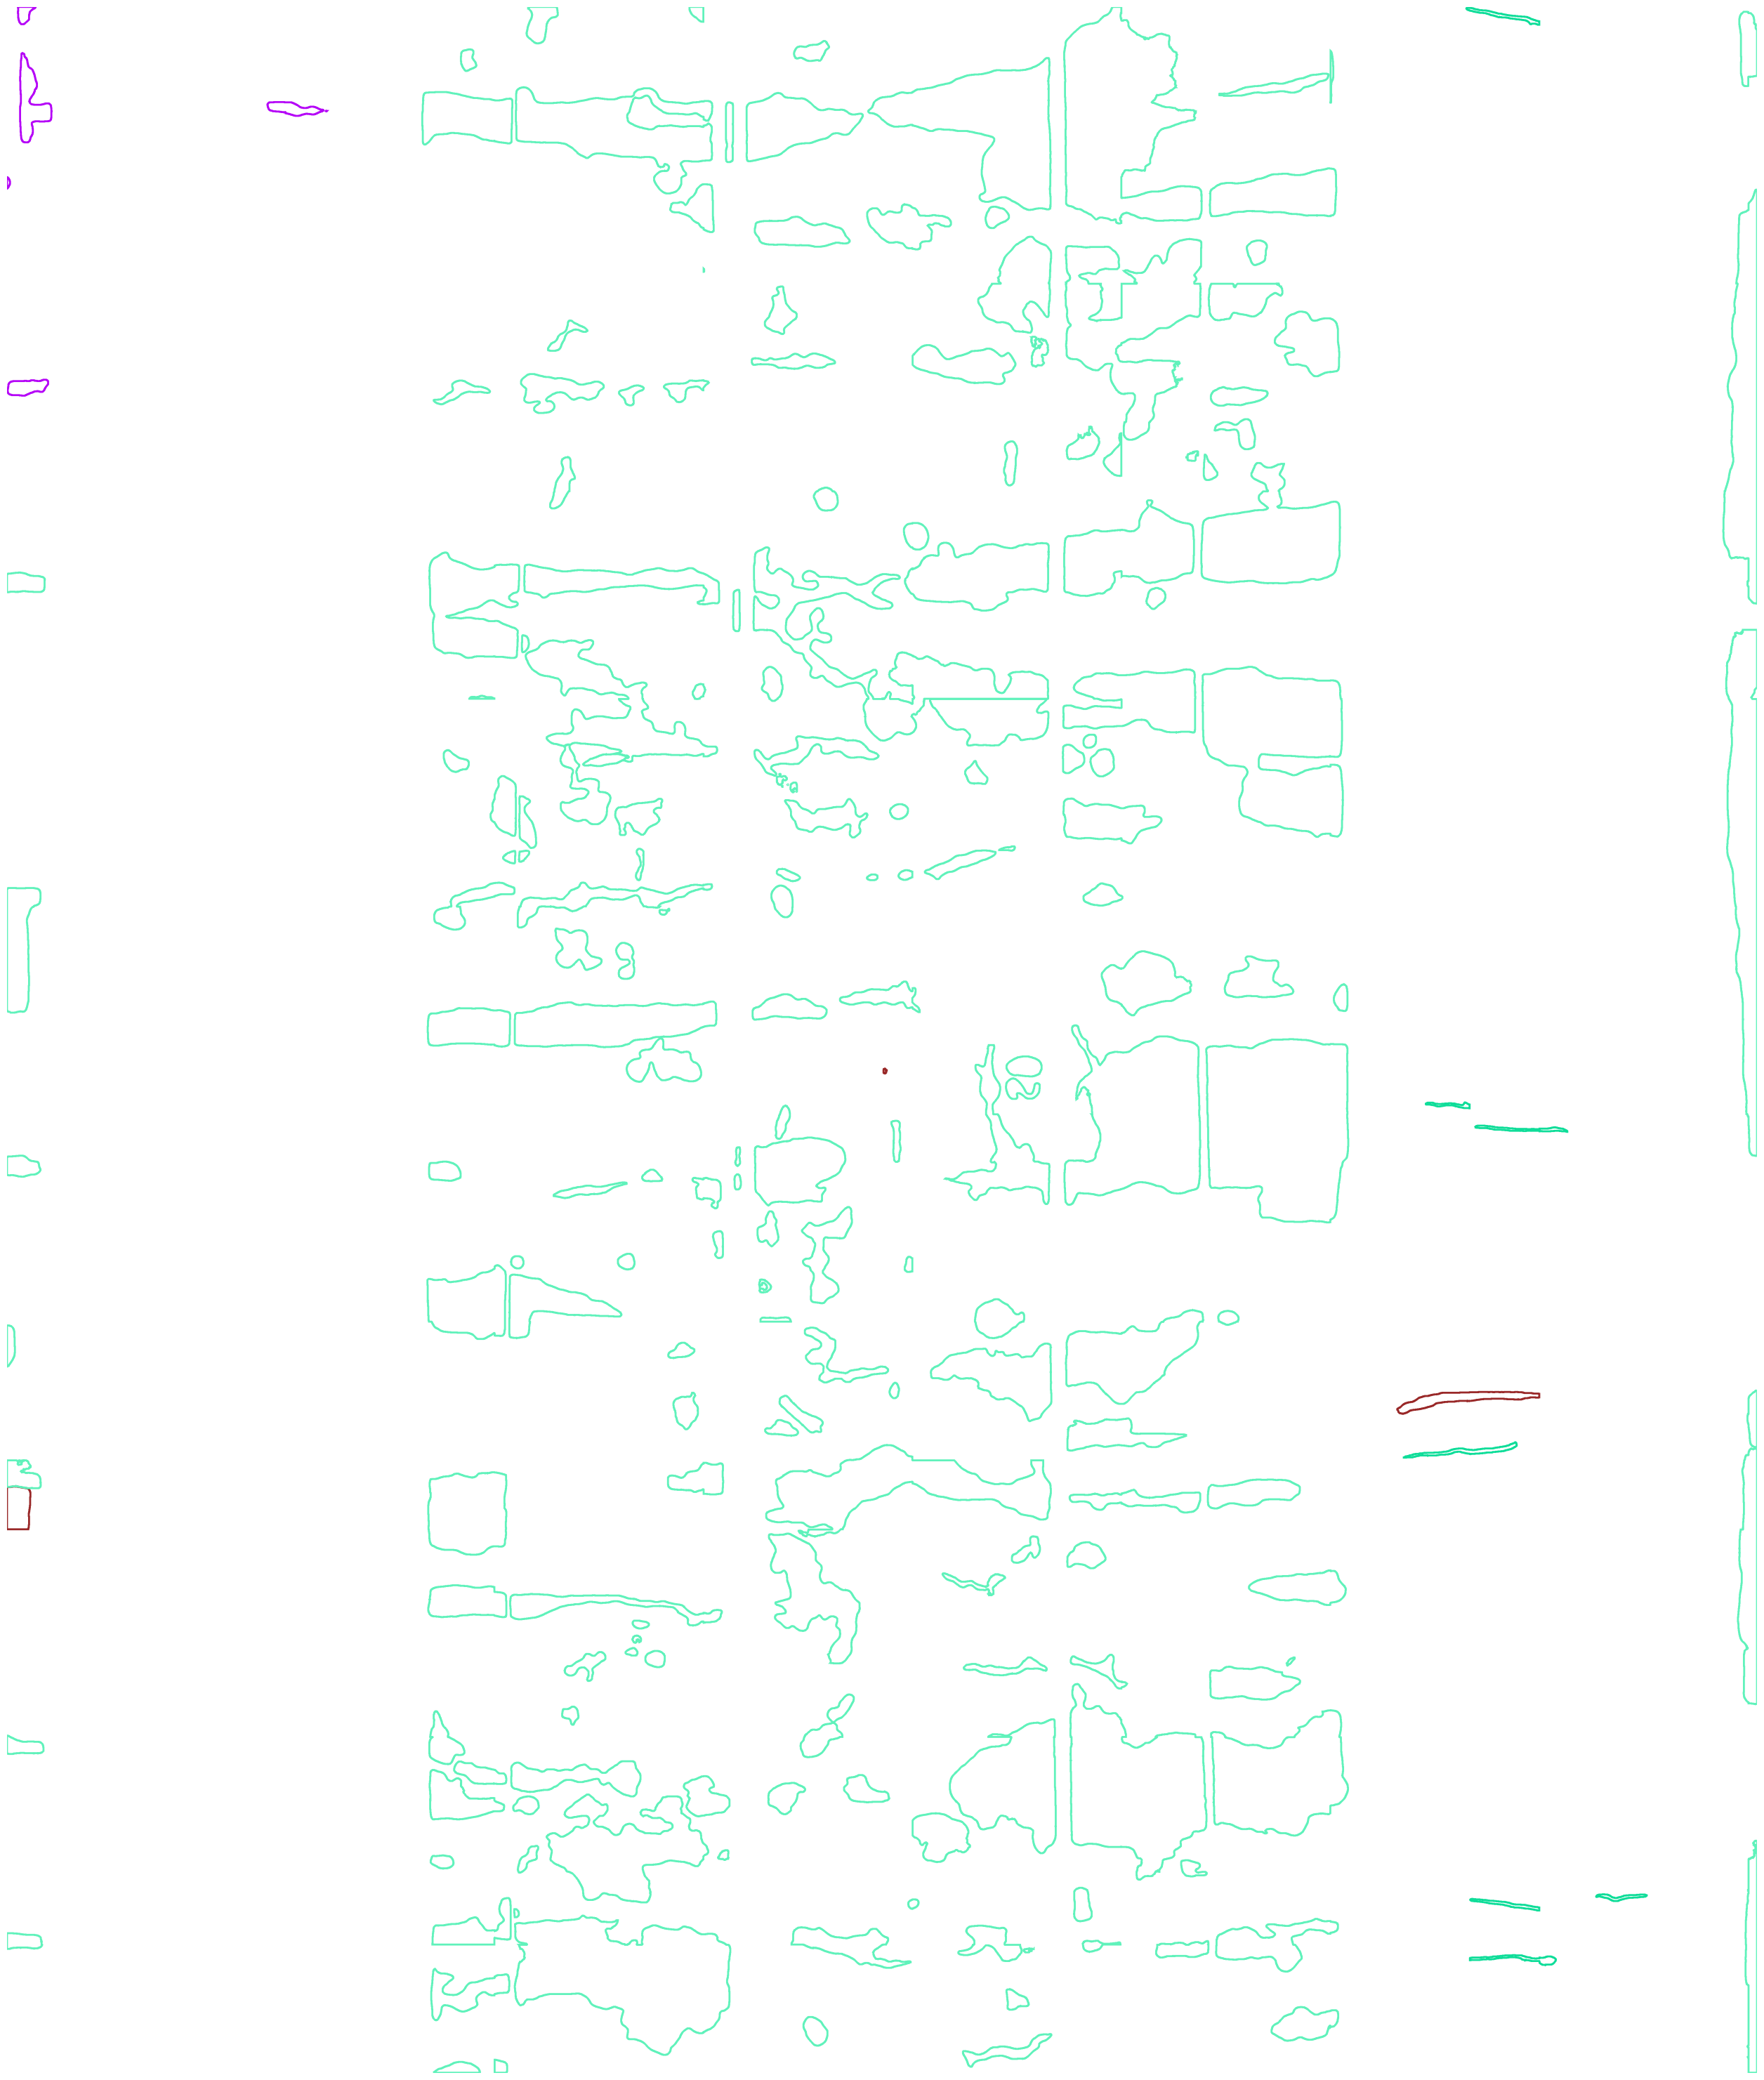

In [3]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# ===================== CONFIGURATION =====================
json_file = "output_things_coco.json"

# ===================== LOAD COCO JSON =====================
with open(json_file) as f:
    coco = json.load(f)

# Extract image dimensions
image_info = coco["images"][0]
width, height = image_info["width"], image_info["height"]

# ===================== CREATE CANVAS =====================
# Scale figure size relative to image resolution
fig, ax = plt.subplots(figsize=(width / 200, height / 200))
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.invert_yaxis()  # In image coordinates, y increases downward
ax.axis("off")

# ===================== GENERATE CATEGORY COLORS =====================
np.random.seed(42)
category_colors = {
    cat["id"]: np.random.rand(3,) for cat in coco["categories"]
}

# ===================== DRAW SEGMENTATION CONTOURS =====================
for ann in coco["annotations"]:
    color = category_colors[ann["category_id"]]
    for seg in ann["segmentation"]:
        pts = np.array(seg).reshape(-1, 2)
        polygon = patches.Polygon(
            pts,
            closed=True,
            fill=False,
            edgecolor=color,
            linewidth=2
        )
        ax.add_patch(polygon)

# ===================== DISPLAY RESULT =====================
plt.show()


In [4]:
import json
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

# ===================== CONFIGURATION =====================
input_json = "output_things_coco.json"
output_json = "output_things_merged_coco.json"
buffer_distance = 145  # Adjustable (in pixels), used to fill small gaps between segments

# ===================== LOAD COCO JSON =====================
with open(input_json) as f:
    coco = json.load(f)

annotations = coco["annotations"]
merged_annotations = []
new_id = 1

# ===================== MERGE CONTOURS =====================
for ann in annotations:
    segs = ann["segmentation"]
    polygons = []

    # Convert segmentation lists to Shapely Polygons
    for seg in segs:
        pts = np.array(seg).reshape(-1, 2)
        if pts.shape[0] >= 3:
            poly = Polygon(pts)
            if not poly.is_valid:
                poly = poly.buffer(0)
            if poly.is_valid and poly.area > 0:
                polygons.append(poly)

    if not polygons:
        continue

    # Apply buffering and union to merge nearby or slightly separated regions
    buffered_polys = [p.buffer(buffer_distance) for p in polygons]
    merged = unary_union(buffered_polys)
    merged = merged.buffer(-buffer_distance)  # Contract back to original shape after merging

    # Generate merged segmentation coordinates
    merged_segs = []
    if merged.geom_type == "Polygon":
        merged_segs.append(np.array(merged.exterior.coords).ravel().tolist())
    elif merged.geom_type == "MultiPolygon":
        for p in merged.geoms:
            merged_segs.append(np.array(p.exterior.coords).ravel().tolist())

    # Compute bounding box and area
    x, y, maxx, maxy = merged.bounds
    w_box = maxx - x
    h_box = maxy - y
    area = float(merged.area)

    merged_annotations.append({
        "id": new_id,
        "image_id": ann["image_id"],
        "category_id": ann["category_id"],
        "bbox": [float(x), float(y), float(w_box), float(h_box)],
        "area": area,
        "segmentation": merged_segs,
        "iscrowd": 0
    })
    new_id += 1

# ===================== SAVE MERGED JSON =====================
coco_output = {
    "images": coco["images"],
    "annotations": merged_annotations,
    "categories": coco["categories"]
}

with open(output_json, "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"✅ Merged COCO JSON has been generated: {output_json}")
print(f"Total number of merged instances: {len(merged_annotations)}")


✅ Merged COCO JSON has been generated: output_things_merged_coco.json
Total number of merged instances: 143


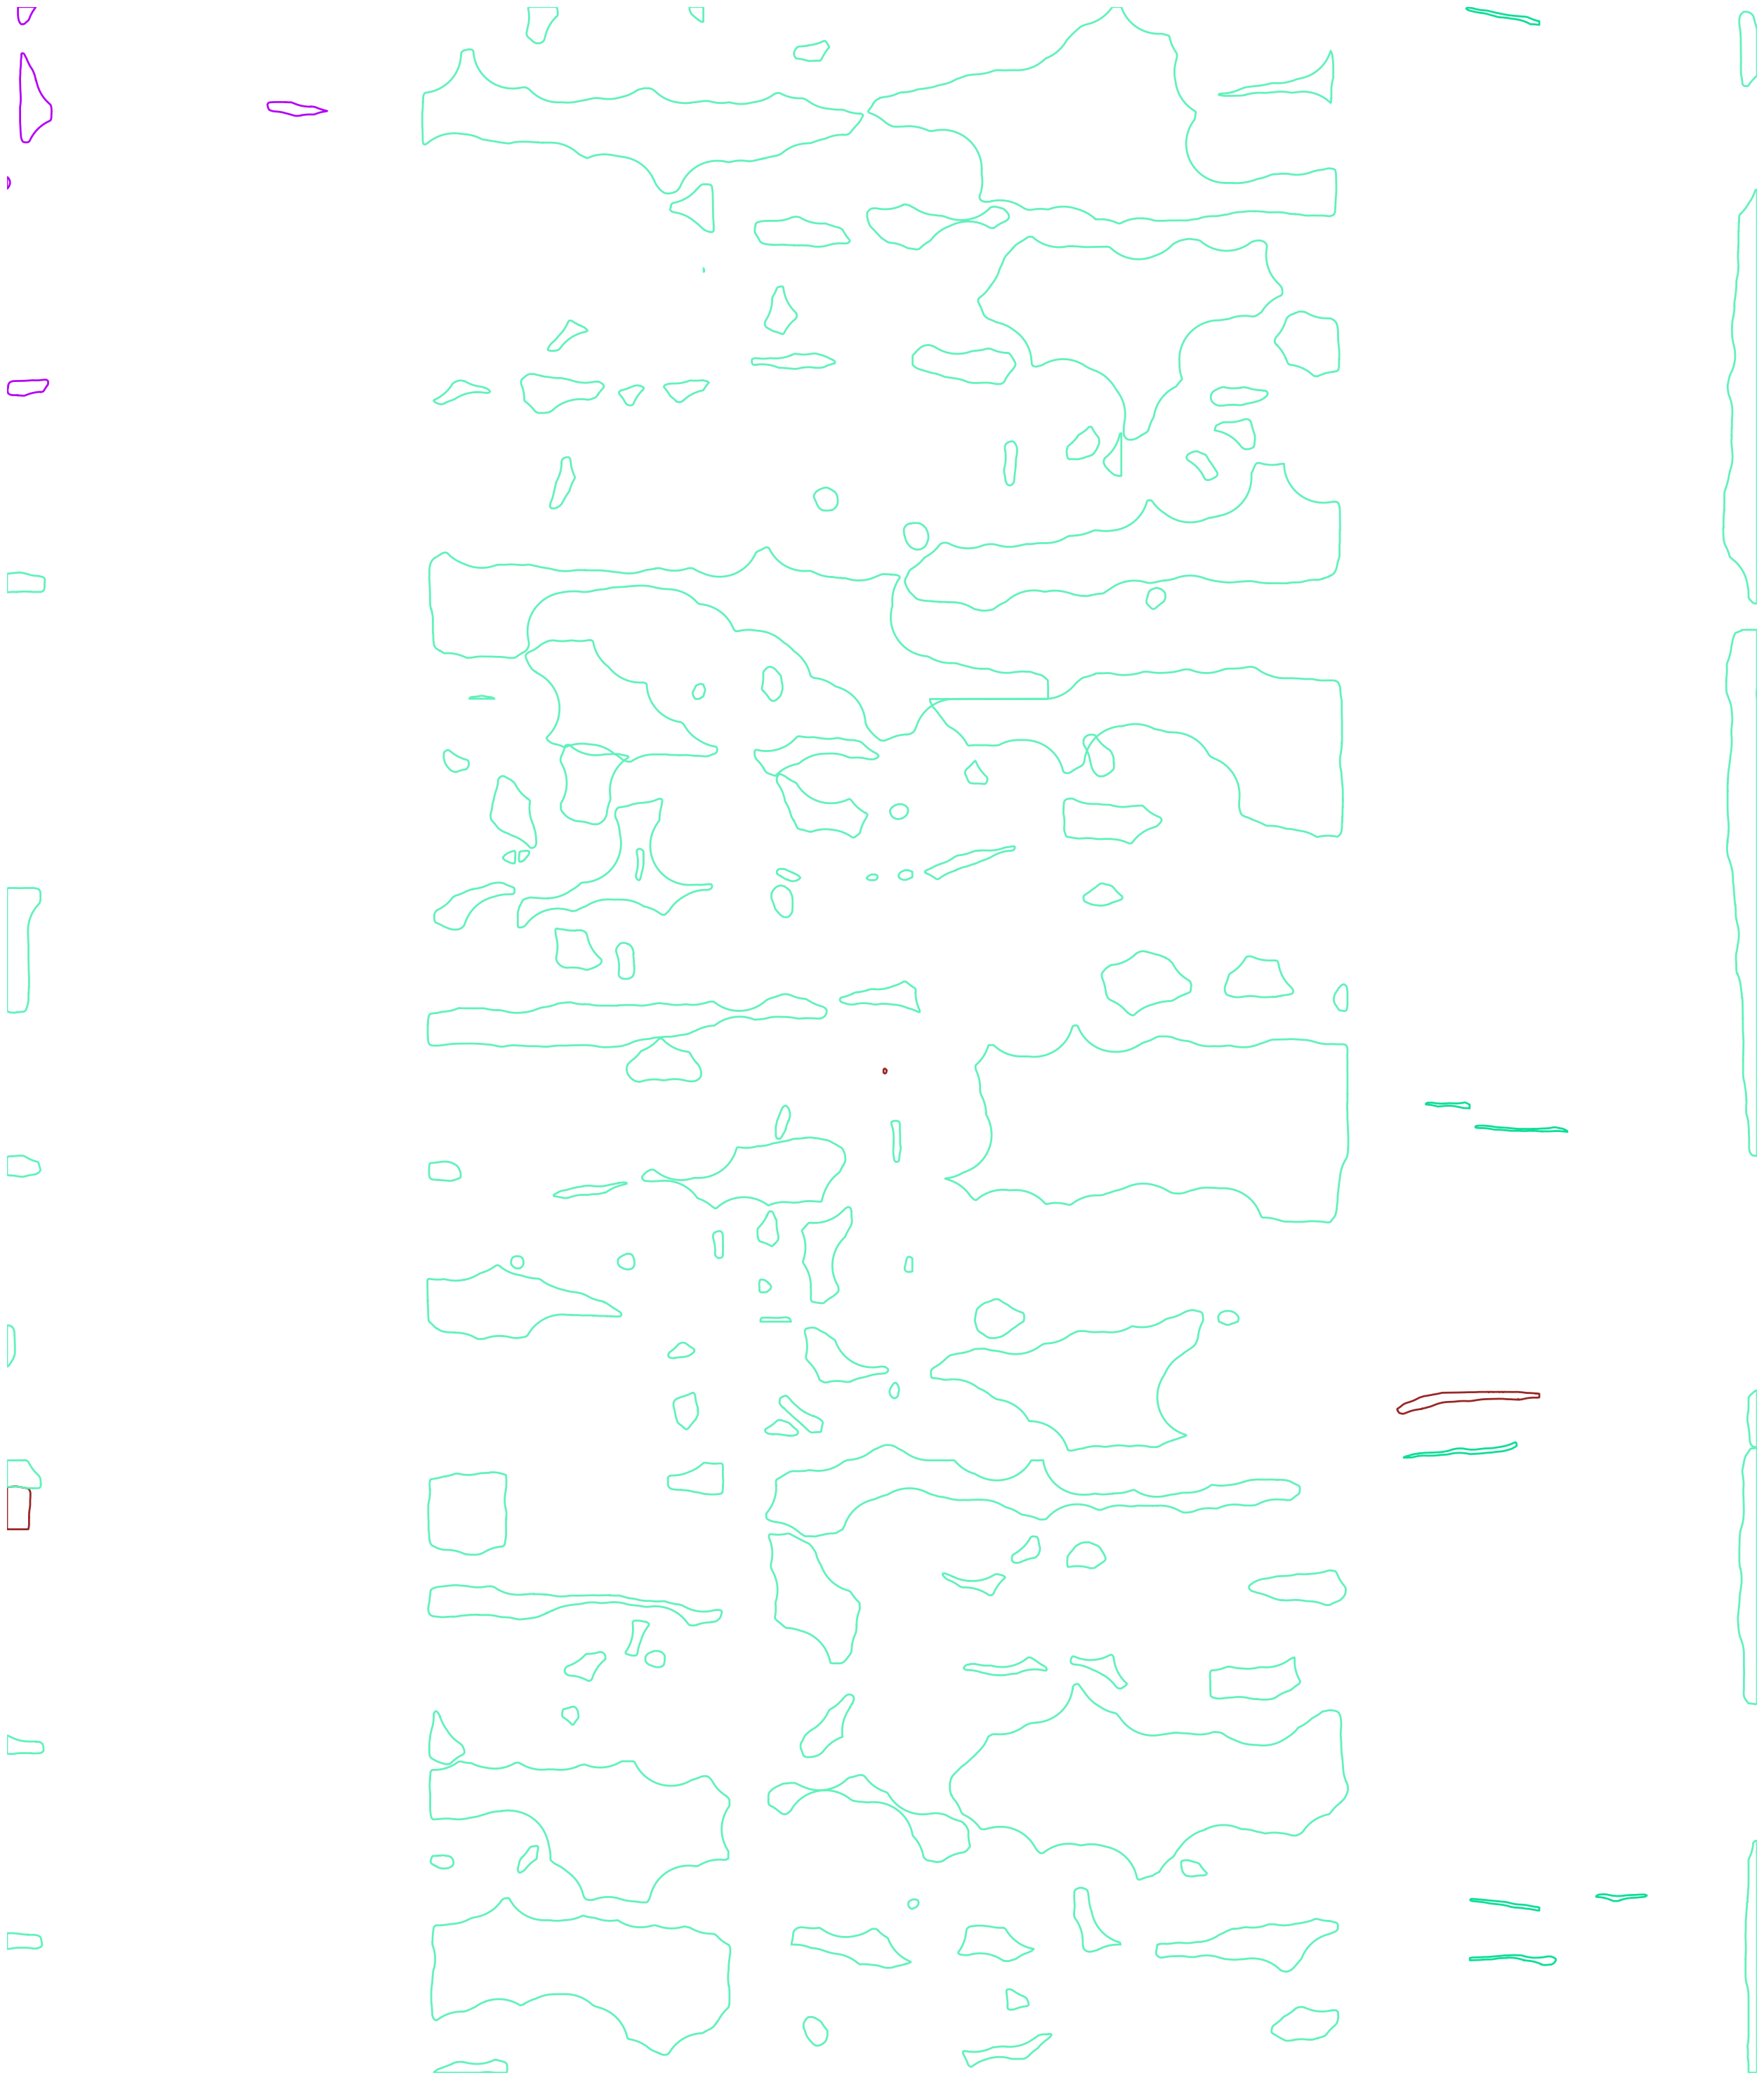

In [5]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# ===================== CONFIGURATION =====================
json_file = "output_things_merged_coco.json"

# ===================== LOAD COCO JSON =====================
with open(json_file) as f:
    coco = json.load(f)

# Extract image dimensions
image_info = coco["images"][0]
width, height = image_info["width"], image_info["height"]

# ===================== CREATE CANVAS =====================
# Scale figure size relative to image resolution
fig, ax = plt.subplots(figsize=(width / 200, height / 200))
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.invert_yaxis()  # In image coordinates, y increases downward
ax.axis("off")

# ===================== GENERATE CATEGORY COLORS =====================
np.random.seed(42)
category_colors = {
    cat["id"]: np.random.rand(3,) for cat in coco["categories"]
}

# ===================== DRAW MERGED POLYGON CONTOURS =====================
for ann in coco["annotations"]:
    color = category_colors[ann["category_id"]]
    for seg in ann["segmentation"]:
        pts = np.array(seg).reshape(-1, 2)
        polygon = patches.Polygon(
            pts,
            closed=True,
            fill=False,
            edgecolor=color,
            linewidth=2
        )
        ax.add_patch(polygon)

# ===================== DISPLAY RESULT =====================
plt.show()


In [6]:
import json
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

# ===================== CONFIGURATION =====================
input_json = "output_things_merged_coco.json"
output_json = "output_things_simplified_coco.json"
simplify_tolerance = 30  # Simplification tolerance (adjust based on image resolution)

# ===================== LOAD COCO JSON =====================
with open(input_json) as f:
    coco = json.load(f)

annotations = coco["annotations"]
simplified_annotations = []
new_id = 1

# ===================== SIMPLIFY CONTOURS =====================
for ann in annotations:
    segs = ann["segmentation"]
    polygons = []

    # Convert segmentations to Shapely polygons
    for seg in segs:
        pts = np.array(seg).reshape(-1, 2)
        if pts.shape[0] >= 3:
            poly = Polygon(pts)
            if not poly.is_valid:
                poly = poly.buffer(0)
            if poly.is_valid and poly.area > 0:
                polygons.append(poly)

    if not polygons:
        continue

    # Merge polygons into a single shape (can keep unary_union even if already merged)
    merged = unary_union(polygons)

    # Simplify the merged polygon geometry
    merged = merged.simplify(simplify_tolerance, preserve_topology=True)

    # Generate simplified segmentation
    merged_segs = []
    if merged.geom_type == "Polygon":
        merged_segs.append(np.array(merged.exterior.coords).ravel().tolist())
    elif merged.geom_type == "MultiPolygon":
        for p in merged.geoms:
            merged_segs.append(np.array(p.exterior.coords).ravel().tolist())

    # Compute bounding box and area
    x, y, maxx, maxy = merged.bounds
    w_box = maxx - x
    h_box = maxy - y
    area = float(merged.area)

    simplified_annotations.append({
        "id": new_id,
        "image_id": ann["image_id"],
        "category_id": ann["category_id"],
        "bbox": [float(x), float(y), float(w_box), float(h_box)],
        "area": area,
        "segmentation": merged_segs,
        "iscrowd": 0
    })
    new_id += 1

# ===================== SAVE SIMPLIFIED JSON =====================
coco_output = {
    "images": coco["images"],
    "annotations": simplified_annotations,
    "categories": coco["categories"]
}

with open(output_json, "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"✅ Simplified COCO JSON has been generated: {output_json}")
print(f"Total number of simplified instances: {len(simplified_annotations)}")


✅ Simplified COCO JSON has been generated: output_things_simplified_coco.json
Total number of simplified instances: 143


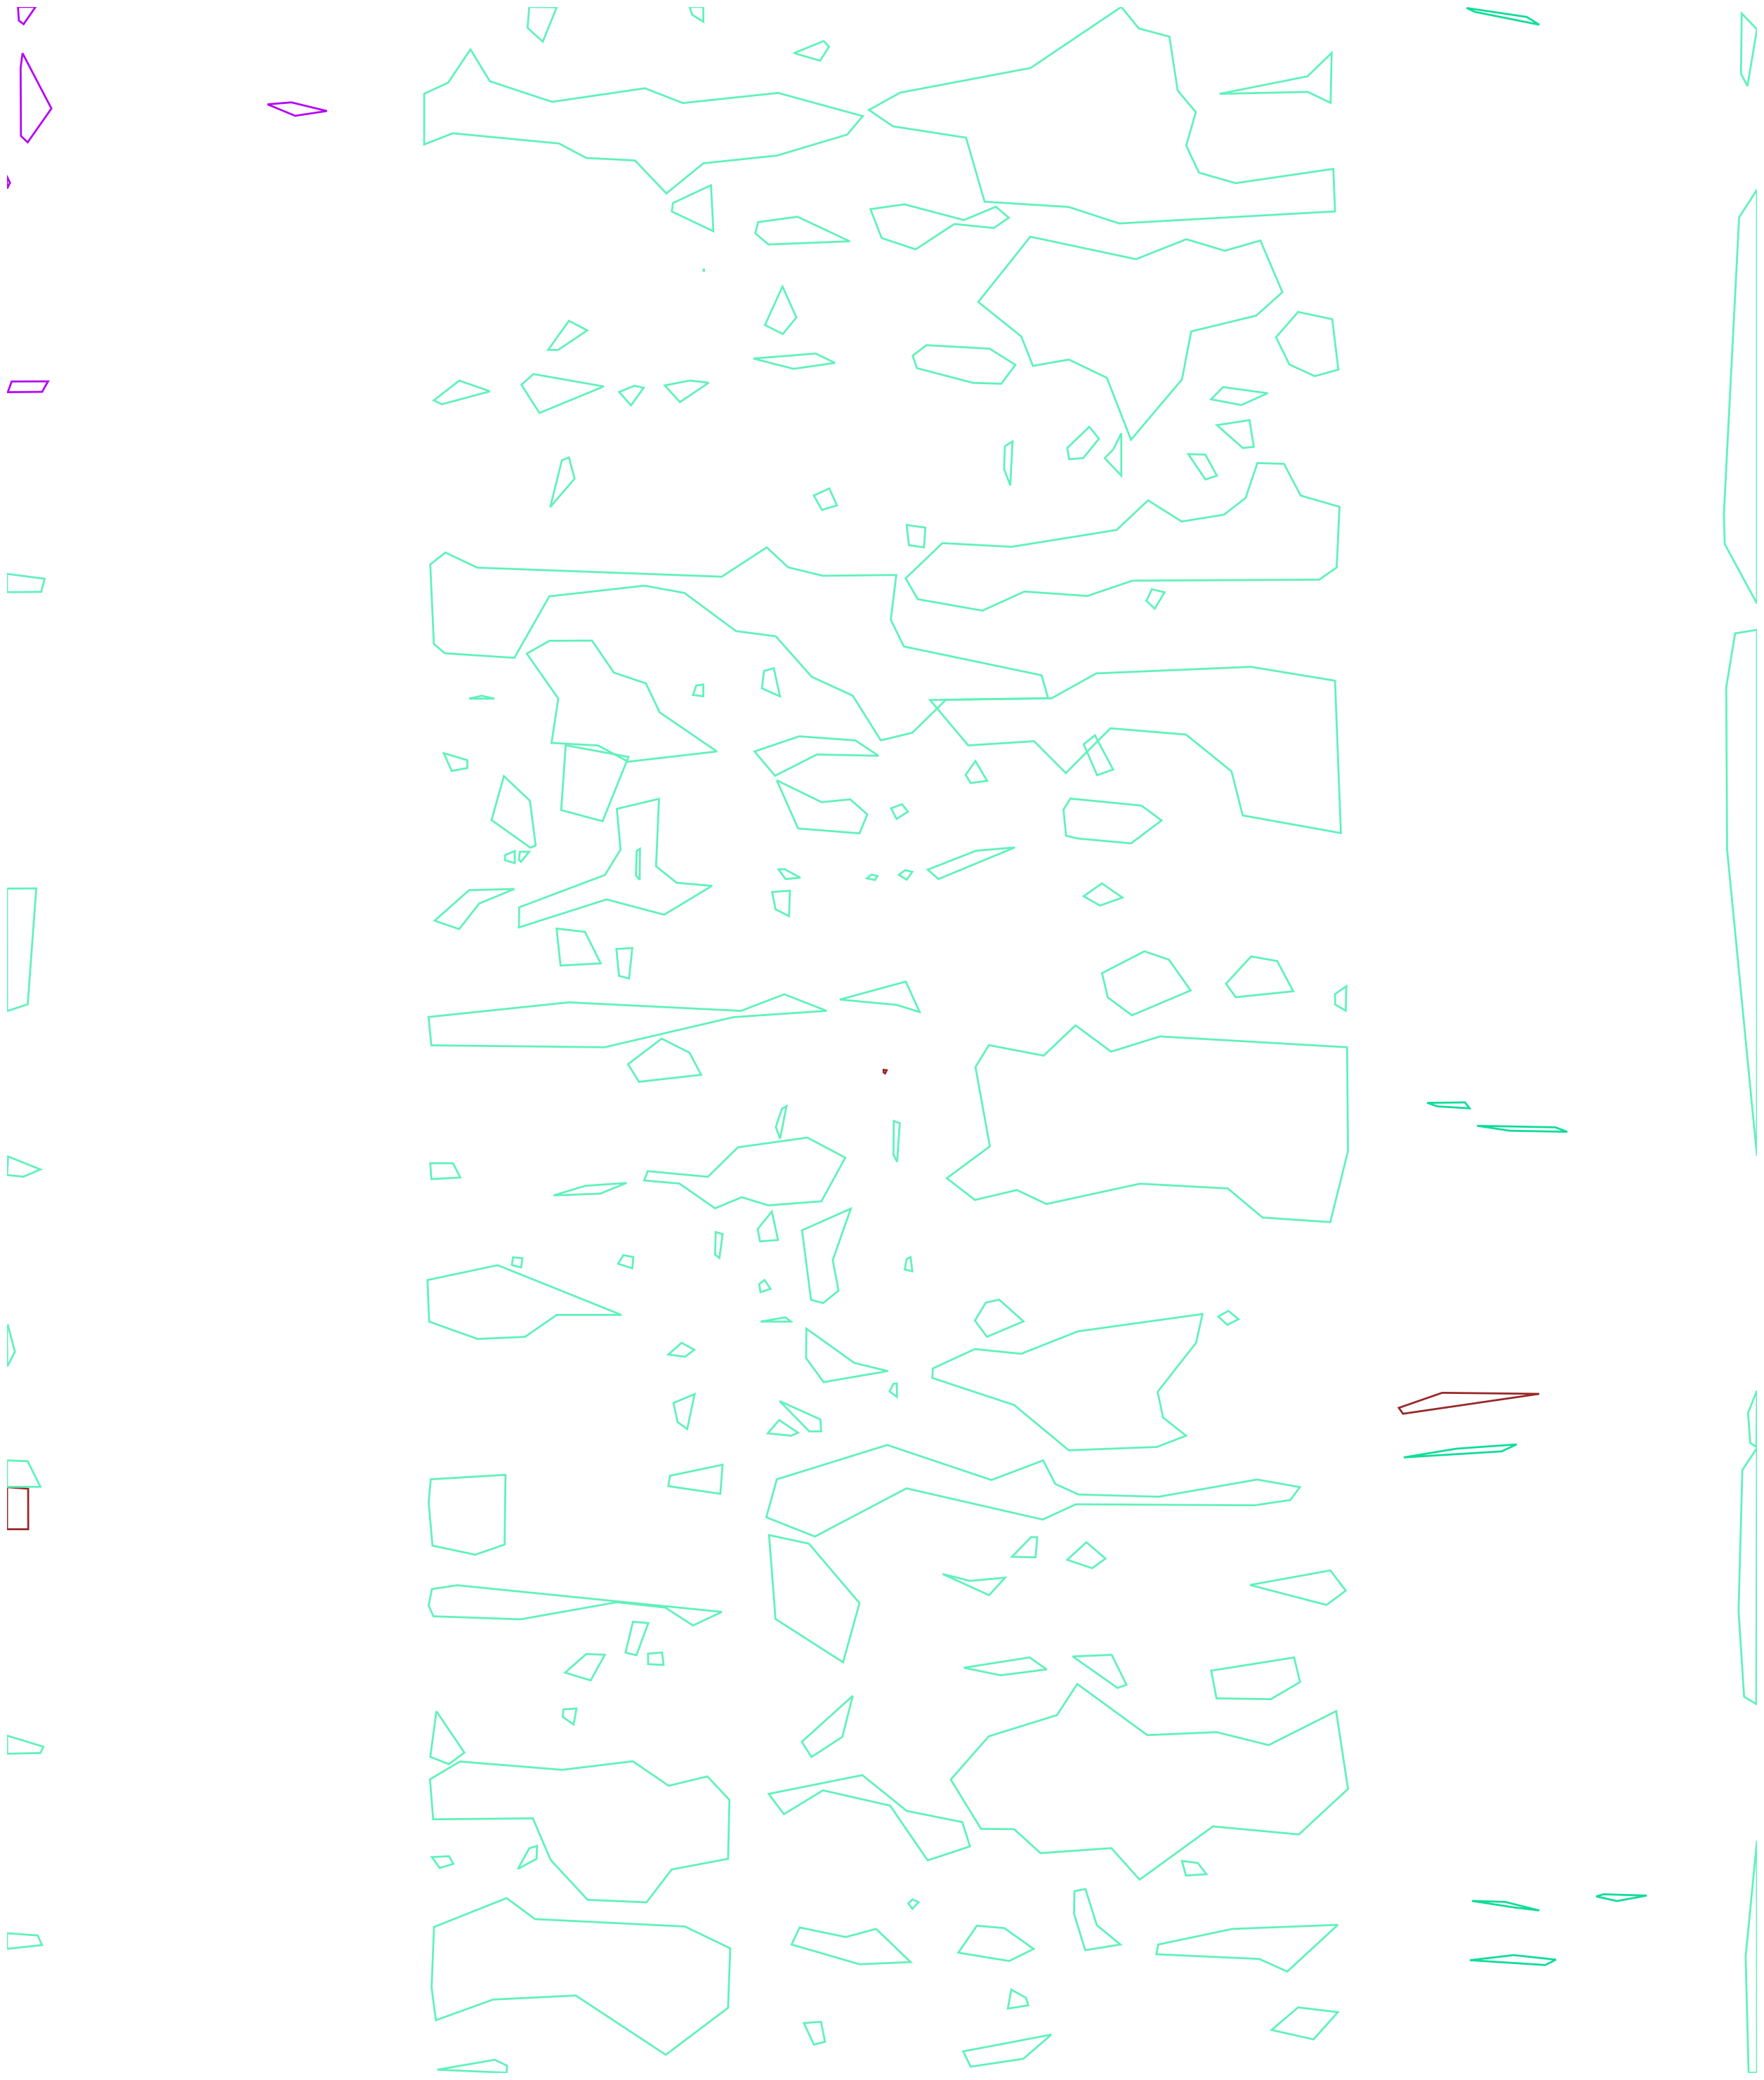

In [7]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# ===================== CONFIGURATION =====================
json_file = "output_things_simplified_coco.json"

# ===================== LOAD COCO JSON =====================
with open(json_file) as f:
    coco = json.load(f)

# Extract image dimensions
image_info = coco["images"][0]
width, height = image_info["width"], image_info["height"]

# ===================== CREATE CANVAS =====================
# Scale figure size relative to image resolution
fig, ax = plt.subplots(figsize=(width / 200, height / 200))
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.invert_yaxis()  # In image coordinates, y increases downward
ax.axis("off")

# ===================== GENERATE CATEGORY COLORS =====================
np.random.seed(42)
category_colors = {
    cat["id"]: np.random.rand(3,) for cat in coco["categories"]
}

# ===================== DRAW SIMPLIFIED POLYGON CONTOURS =====================
for ann in coco["annotations"]:
    color = category_colors[ann["category_id"]]
    for seg in ann["segmentation"]:
        pts = np.array(seg).reshape(-1, 2)
        polygon = patches.Polygon(
            pts,
            closed=True,
            fill=False,
            edgecolor=color,
            linewidth=2
        )
        ax.add_patch(polygon)

# ===================== DISPLAY RESULT =====================
plt.show()


In [9]:
import json
import numpy as np

# ===================== CONFIGURATION =====================
json_file = "train.json"

# ===================== LOAD COCO JSON =====================
with open(json_file) as f:
    coco = json.load(f)

annotations = coco["annotations"]
categories = coco["categories"]

# Build mapping: category_id -> category_name
cat_id_to_name = {cat["id"]: cat["name"] for cat in categories}

# Prepare a list to store areas for each category
cat_areas = {cat_id: [] for cat_id in cat_id_to_name.keys()}

# ===================== COLLECT AREA DATA =====================
for ann in annotations:
    area = ann.get("area", 0)
    cat_id = ann["category_id"]
    if cat_id in cat_areas:
        cat_areas[cat_id].append(area)

# ===================== CALCULATE 20% / 80% PERCENTILE THRESHOLDS =====================
print("📊 Area distribution (20th / 80th percentile) by category:")
for cat_id, areas in cat_areas.items():
    if not areas:
        continue
    areas_np = np.array(areas)
    lower20 = np.percentile(areas_np, 20)
    upper20 = np.percentile(areas_np, 80)
    print(f"  {cat_id_to_name[cat_id]:<12}: 20th={lower20:.2f}, 80th={upper20:.2f}")


📊 Area distribution (20th / 80th percentile) by category:
  Seepage     : 20th=4750.80, 80th=56454.70
  Corrosion   : 20th=7952.54, 80th=108253.40
  Damaged_joint: 20th=8090.27, 80th=26642.14
  Spalling    : 20th=2020.68, 80th=15934.60
  Crack       : 20th=1455.52, 80th=5770.44
  Tunnel      : 20th=14206246.30, 80th=31591933.61
  Equipment   : 20th=1401679.20, 80th=2479260.46
  Signs       : 20th=13883.89, 80th=129291.06
  Repair_part : 20th=567408.59, 80th=2976032.35


✅ Loaded 143 instance annotations from output_things_simplified_coco.json.

🖼️  Drawing polygons (skipping instances with area < 0)...
✅ Drawing complete! Displayed 143 / 143 instances.


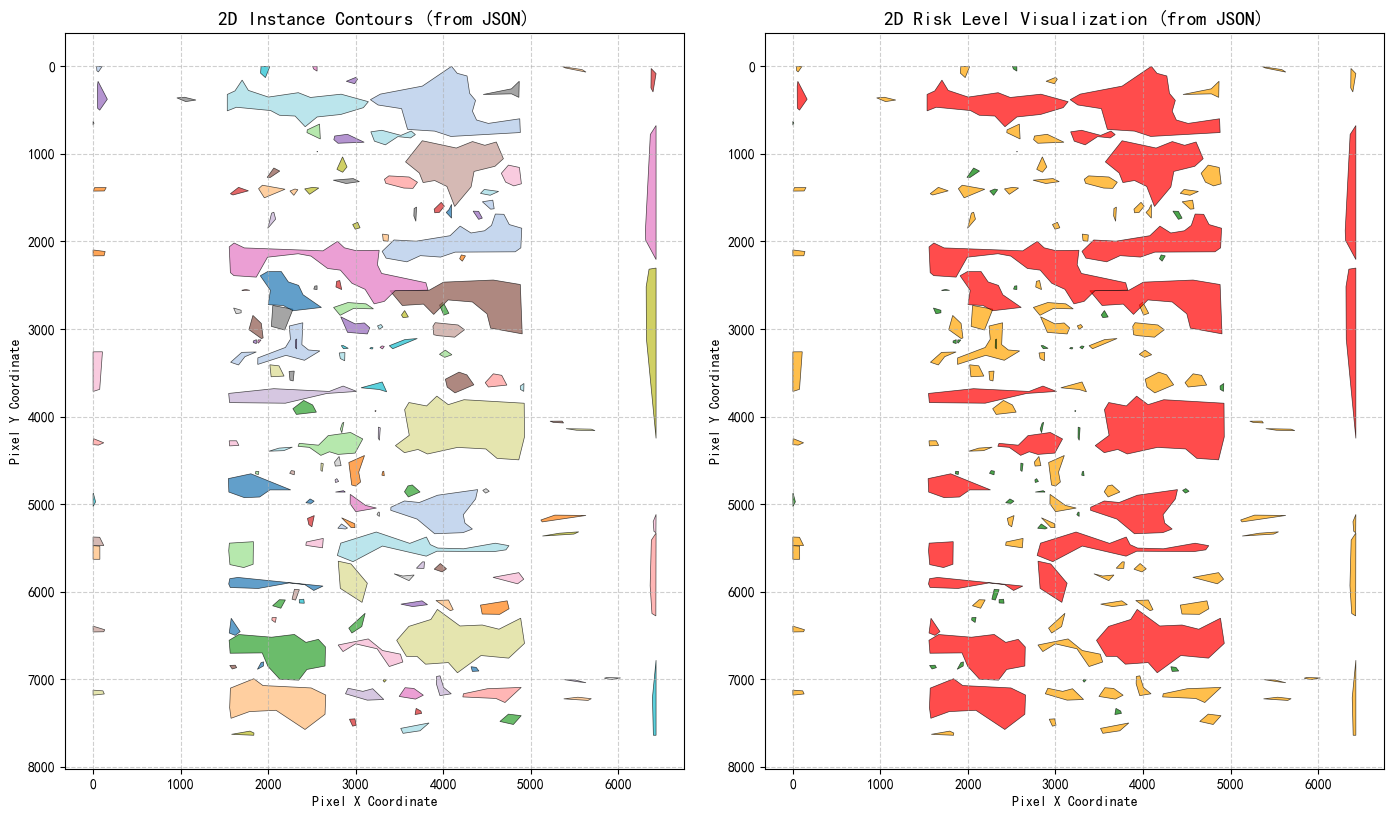

In [10]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np

# ====================================================
# CONFIGURATION
simplified_json_path = "output_things_simplified_coco.json"
original_json_path = "output_things_coco.json"

# ====================================================
# AREA FILTER — removes tiny instances to reduce visual noise.
# Based on pixel area of each instance. Set to 0 to show all.
MIN_AREA_THRESHOLD = 0

# ====================================================
# Font configuration for Chinese labels and minus signs
try:
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    plt.rcParams["axes.unicode_minus"] = False
except Exception:
    print("⚠️  Warning: 'SimHei' font not found. Chinese labels may not render properly.")

# ====================================================
# 1. LOAD JSON DATA
try:
    with open(simplified_json_path) as f:
        coco_data = json.load(f)
    with open(original_json_path) as f:
        original_coco = json.load(f)
except FileNotFoundError as e:
    print(f"❌ Error: File not found - {e.filename}. Please check the file path.")
    exit()

annotations = coco_data["annotations"]
print(f"✅ Loaded {len(annotations)} instance annotations from {simplified_json_path}.")

# Build mapping: category_id -> category_name (lowercase for consistency)
cat_id_to_name = {cat["id"]: cat["name"].lower() for cat in coco_data["categories"]}

# Build mapping: instance_id -> area (using original COCO file for accuracy)
instance_area_map = {ann["id"]: ann["area"] for ann in original_coco["annotations"]}

# ====================================================
# 2. RISK LEVEL CALCULATION LOGIC (matches your CSV generator)
thresholds = {
    "seepage": {"low": 4750.80, "high": 56454.70},
    "corrosion": {"low": 7952.54, "high": 108253.40},
    "damaged_joint": {"low": 8090.27, "high": 26642.14},
    "spalling": {"low": 2020.68, "high": 15934.60},
    "crack": {"low": 1455.52, "high": 5770.44},
}

def calculate_risk(category_name, area):
    """Determine risk level based on defect category and instance area."""
    if category_name in thresholds:
        th = thresholds[category_name]
        if area > th["high"]:
            return 1  # High risk
        elif area < th["low"]:
            return 3  # Low risk
        else:
            return 2  # Medium risk
    return 2  # Default to medium risk

# ====================================================
# 3. PREPARE PLOTTING
fig, (ax_inst, ax_risk) = plt.subplots(1, 2, figsize=(18, 9))

# Colormaps
cmap = plt.colormaps["tab20"]
risk_colors = {1: "red", 2: "orange", 3: "green"}

# ====================================================
# 4. DRAW FILLED POLYGONS
drawn_count = 0
print(f"\n🖼️  Drawing polygons (skipping instances with area < {MIN_AREA_THRESHOLD})...")

for ann in annotations:
    instance_id = ann["id"]
    area = instance_area_map.get(instance_id, 0)

    # Apply area filter
    if area < MIN_AREA_THRESHOLD:
        continue

    category_name = cat_id_to_name.get(ann["category_id"], "unknown")
    risk_val = calculate_risk(category_name, area)

    # ann['segmentation'] is a list of polygons (usually one per instance)
    for seg in ann["segmentation"]:
        points = np.array(seg).reshape(-1, 2)
        if len(points) >= 3:
            # --- Left: instance shapes (colored by instance ID) ---
            inst_color = cmap(instance_id % cmap.N)
            poly_inst = MplPolygon(
                points,
                closed=True,
                facecolor=inst_color,
                edgecolor="black",
                linewidth=0.5,
                alpha=0.7,
            )
            ax_inst.add_patch(poly_inst)

            # --- Right: risk visualization (colored by risk level) ---
            risk_color = risk_colors.get(risk_val, "gray")
            poly_risk = MplPolygon(
                points,
                closed=True,
                facecolor=risk_color,
                edgecolor="black",
                linewidth=0.5,
                alpha=0.7,
            )
            ax_risk.add_patch(poly_risk)

    drawn_count += 1

print(f"✅ Drawing complete! Displayed {drawn_count} / {len(annotations)} instances.")

# ====================================================
# 5. FINALIZE PLOTS
for ax in [ax_inst, ax_risk]:
    ax.set_aspect("equal")
    ax.autoscale_view()
    ax.invert_yaxis()
    ax.set_xlabel("Pixel X Coordinate")
    ax.set_ylabel("Pixel Y Coordinate")
    ax.grid(True, linestyle="--", alpha=0.6)

ax_inst.set_title("2D Instance Contours (from JSON)", fontsize=14)
ax_risk.set_title("2D Risk Level Visualization (from JSON)", fontsize=14)

plt.tight_layout(rect=[0, 0.03, 0.8, 0.95])
plt.show()


In [11]:
import json
import csv
import numpy as np
import cv2  # OpenCV for geometric operations

# =====================================================
# CONFIGURATION
simplified_json = "output_things_simplified_coco.json"
original_json = "output_things_coco.json"
output_csv = "2d_point_info.csv"

# --- Real-world dimensions (meters) ---
REAL_WIDTH_METERS = 18.66
REAL_HEIGHT_METERS = 20.0
# =====================================================

# ===================== 1. LOAD ALL DATA =====================
with open(simplified_json) as f:
    simplified_coco = json.load(f)

with open(original_json) as f:
    original_coco = json.load(f)

# Build mapping: category_id -> category_name
cat_id_to_name = {cat["id"]: cat["name"].lower() for cat in simplified_coco["categories"]}

# Build mapping: instance_id -> original pixel area
original_area_map = {ann["id"]: ann["area"] for ann in original_coco["annotations"]}

# Get image dimensions and compute area conversion factor
if not simplified_coco.get("images"):
    print("❌ Error: No 'images' field found in simplified JSON. Area conversion cannot proceed.")
    exit()

image_info = simplified_coco["images"][0]
image_width_px = image_info["width"]
image_height_px = image_info["height"]

# Conversion from pixel area to real-world area (m² per pixel²)
area_conversion_factor = (REAL_WIDTH_METERS * REAL_HEIGHT_METERS) / (image_width_px * image_height_px)
print(f"✅ Area conversion factor computed: {area_conversion_factor:.8f} m²/px²")

# ===================== 2. DEFINE RISK THRESHOLDS =====================
thresholds = {
    "seepage": {"low": 4750.80, "high": 56454.70},
    "corrosion": {"low": 7952.54, "high": 108253.40},
    "damaged_joint": {"low": 8090.27, "high": 26642.14},
    "spalling": {"low": 2020.68, "high": 15934.60},
    "crack": {"low": 1455.52, "high": 5770.44}
}
# =====================================================

# ===================== 3. SPLIT MULTI-PART INSTANCES =====================
print("🔄 Processing and splitting multi-part instances...")
new_annotations = []
max_id = 0
if simplified_coco["annotations"]:
    max_id = max(ann["id"] for ann in simplified_coco["annotations"])
new_instance_id_counter = max_id + 1

original_ann_count = len(simplified_coco["annotations"])

for ann in simplified_coco["annotations"]:
    instance_id = ann["id"]

    # 1. Get original pixel area
    original_pixel_area = original_area_map.get(instance_id, 0)
    # 2. Convert to real-world area (m²)
    real_world_area = original_pixel_area * area_conversion_factor
    # 3. Compute risk level based on thresholds
    cat_name = cat_id_to_name.get(ann["category_id"], "unknown")
    risk = 2  # Default medium risk
    if cat_name in thresholds:
        th = thresholds[cat_name]
        if original_pixel_area > th["high"]:
            risk = 1  # High risk
        elif original_pixel_area < th["low"]:
            risk = 3  # Low risk
        else:
            risk = 2  # Medium risk

    segmentations = ann["segmentation"]

    # --- Case 1: Single-part instance ---
    if len(segmentations) == 1:
        ann["area"] = real_world_area
        ann["risk"] = risk
        poly_points = np.array(segmentations[0]).reshape(-1, 2).astype(np.int32)
        x, y, w, h = cv2.boundingRect(poly_points)
        ann["bbox"] = [x, y, w, h]
        new_annotations.append(ann)

    # --- Case 2: Multi-part instance (split into independent instances) ---
    elif len(segmentations) > 1:
        for seg in segmentations:
            poly_points = np.array(seg).reshape(-1, 2).astype(np.int32)

            if len(poly_points) < 3:
                continue

            new_ann = {
                "image_id": ann["image_id"],
                "category_id": ann["category_id"],
                "iscrowd": ann["iscrowd"],
                "id": new_instance_id_counter,
                "segmentation": [seg],
                "area": real_world_area,
                "risk": risk,
            }

            x, y, w, h = cv2.boundingRect(poly_points)
            new_ann["bbox"] = [x, y, w, h]

            new_annotations.append(new_ann)
            new_instance_id_counter += 1

print(f"✅ Splitting complete! Original {original_ann_count} instances were expanded into {len(new_annotations)} total instances.")

# ===================== 4. EXPORT TO CSV =====================
print(f"💾 Generating CSV file: {output_csv}")
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["instance_id", "category_name", "area_m2", "risk", "x", "y"])

    for ann in new_annotations:
        instance_id = ann["id"]
        cat_name = cat_id_to_name[ann["category_id"]]
        area_to_write = ann["area"]
        risk_to_write = ann["risk"]

        for seg in ann["segmentation"]:
            pts = np.array(seg).reshape(-1, 2).astype(int)
            for x, y in pts:
                writer.writerow([instance_id, cat_name, area_to_write, risk_to_write, x, y])

print(f"✅ CSV successfully generated: {output_csv}")


✅ Area conversion factor computed: 0.00000759 m²/px²
🔄 Processing and splitting multi-part instances...
✅ Splitting complete! Original 143 instances were expanded into 152 total instances.
💾 Generating CSV file: 2d_point_info.csv
✅ CSV successfully generated: 2d_point_info.csv


In [12]:
import pandas as pd
import numpy as np
import cv2  # OpenCV for efficient convex hull computation
from tqdm.notebook import tqdm  # For a user-friendly progress bar

# ===================== CONFIGURATION =====================
input_csv = "2d_point_info.csv"
output_csv = "2d_point_info_convexhull.csv"  # Output file name

# ===================== LOAD DATA =====================
print(f"Loading data from {input_csv}...")
try:
    df = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"❌ Error: Input file '{input_csv}' not found. Please check the path.")
    exit()

# Group by instance_id — this is our processing unit
groups = df.groupby("instance_id")
print(f"✅ Data loaded. Found {len(groups)} unique instances to process.")

# List to store all new rows (most efficient approach)
all_new_rows = []

# ===================== CORE PROCESSING LOOP =====================
print("Computing convex hulls for each instance...")
# Use tqdm to show a progress bar
for instance_id, group in tqdm(groups, desc="Processing instances"):

    # --- 1. Inherit metadata (key constraint) ---
    # All rows in the group share the same metadata, so we only need the first row
    first_row = group.iloc[0]
    meta_data = {col: first_row[col] for col in df.columns if col not in ['x', 'y']}

    # --- 2. Extract points and compute convex hull ---
    points = group[['x', 'y']].values.astype(np.int32)

    # A valid convex hull requires at least 3 points
    if len(points) < 3:
        continue

    try:
        # a. Compute convex hull using OpenCV
        # cv2.convexHull returns points in order
        hull_points = cv2.convexHull(points)

        # --- 3. Generate new rows ---
        if hull_points is not None and len(hull_points) >= 3:
            # Reshape from (N,1,2) to (N,2)
            optimized_points = hull_points.reshape(-1, 2)

            # For each point in the new hull, create a row and inherit metadata
            for x, y in optimized_points:
                new_row = [meta_data.get(col) for col in df.columns if col not in ['x', 'y']]
                new_row.extend([x, y])  # Append new x, y coordinates
                all_new_rows.append(new_row)

    except Exception as e:
        print(f"\n⚠️ Warning: Error processing instance ID {instance_id}, skipped. Error: {e}")
        continue

# ===================== SAVE RESULTS =====================
print("\nConvex hull processing complete. Saving to new file...")
if all_new_rows:
    output_df = pd.DataFrame(all_new_rows, columns=df.columns)
    output_df.to_csv(output_csv, index=False)
    print(f"✅ Optimized convex hull data successfully saved to: {output_csv}")
else:
    print("⚠️ Warning: No valid convex hulls were generated. No output file created.")


Loading data from 2d_point_info.csv...
✅ Data loaded. Found 152 unique instances to process.
Computing convex hulls for each instance...


Processing instances:   0%|          | 0/152 [00:00<?, ?it/s]


Convex hull processing complete. Saving to new file...
✅ Optimized convex hull data successfully saved to: 2d_point_info_convexhull.csv


✅ Loaded 702 points from 2d_point_info_convexhull.csv.
✅ Found 151 unique instances in the data.

Drawing contour lines, skipping instances with fewer than 0 points...
✅ Drawing complete! Displayed contours for 151 / 151 instances.


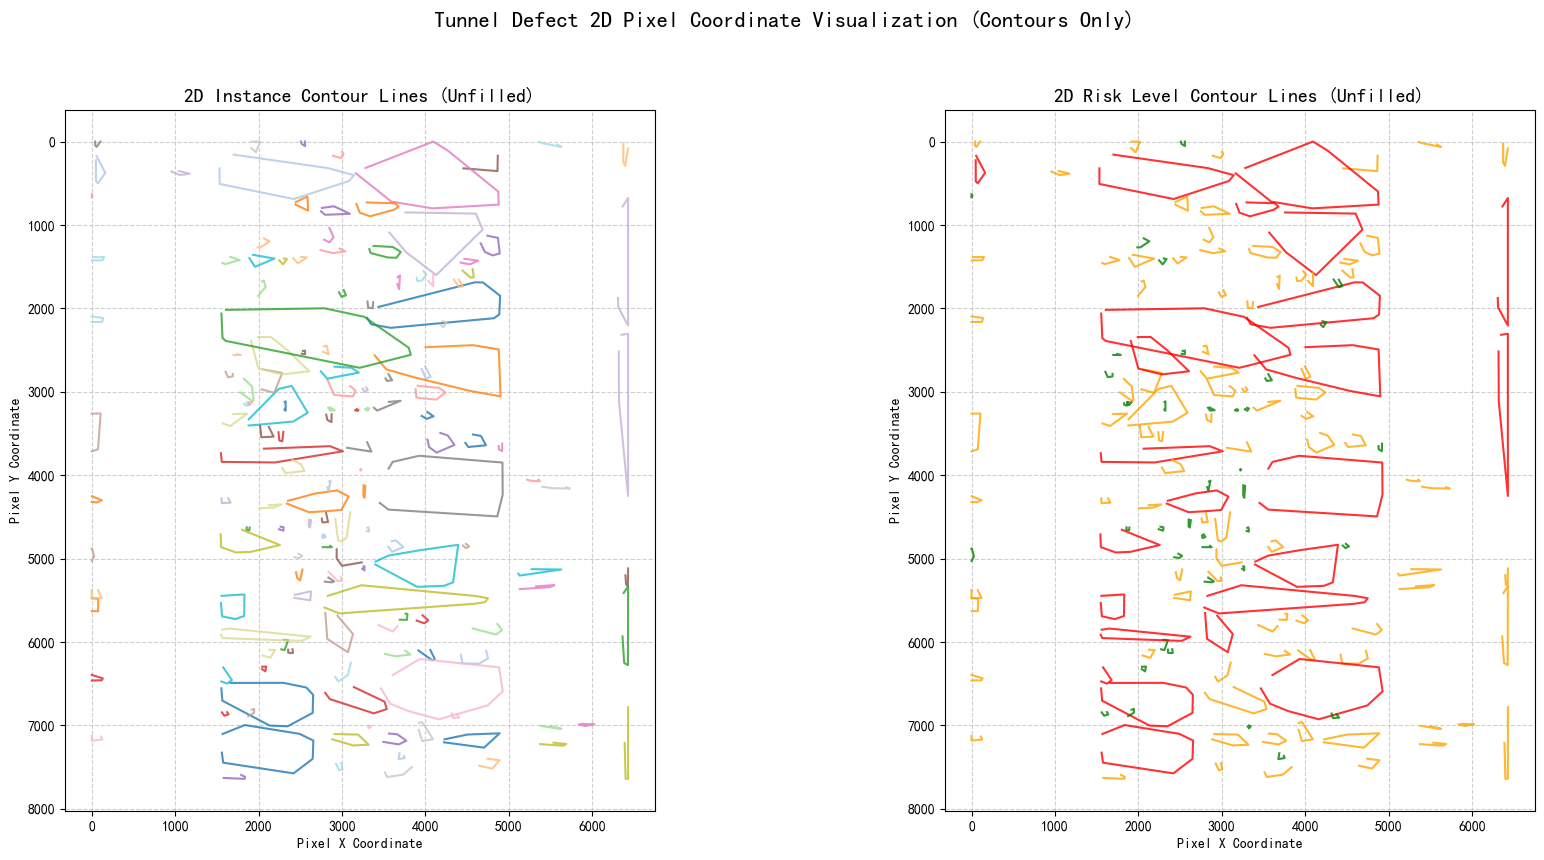

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ====================================================
# CONFIGURATION
csv_path = "2d_point_info_convexhull.csv"

# ====================================================
# Point threshold filter
# For drawing lines, we need at least 2 points. 
# Set a low threshold to remove isolated noise points.
MIN_POINTS_THRESHOLD = 0 

# ====================================================
# Set font and negative sign display
try:
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    plt.rcParams["axes.unicode_minus"] = False
except Exception:
    print("⚠️ Warning: 'SimHei' font not found. Chinese labels may not display correctly.")

# ====================================================
# 1. LOAD DATA
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"❌ Error: CSV file '{csv_path}' not found. Please check the path.")
    exit()

# Ensure proper data types
df = df.dropna(subset=["x", "y"])
df[["x", "y"]] = df[["x", "y"]].astype(float)
df["instance_id"] = df["instance_id"].astype(int)
df["risk"] = df["risk"].astype(int)
print(f"✅ Loaded {len(df)} points from {csv_path}.")

# ====================================================
# 2. Group by instance ID
groups = df.groupby("instance_id")
print(f"✅ Found {len(groups)} unique instances in the data.")

# ====================================================
# 3. PREPARE PLOT
fig, (ax_inst, ax_risk) = plt.subplots(1, 2, figsize=(18, 9))

# Color mappings
cmap = plt.colormaps["tab20"]
risk_colors = {1: "red", 2: "orange", 3: "green"}

# ====================================================
# 4. Draw instance and risk contour lines
drawn_count = 0
print(f"\nDrawing contour lines, skipping instances with fewer than {MIN_POINTS_THRESHOLD} points...")

for i, (instance_id, group) in enumerate(groups):
    if len(group) < MIN_POINTS_THRESHOLD:
        continue

    points = group[["x", "y"]].values

    # --- Split X and Y coordinates for plotting ---
    x_coords = points[:, 0]
    y_coords = points[:, 1]

    # --- Left plot: Instance contours colored by ID ---
    inst_color = cmap(i % cmap.N)
    ax_inst.plot(x_coords, y_coords, color=inst_color, linewidth=1.5, alpha=0.8)

    # --- Right plot: Risk level contours colored by risk ---
    risk_val = group["risk"].iloc[0]
    risk_color = risk_colors.get(risk_val, "gray")
    ax_risk.plot(x_coords, y_coords, color=risk_color, linewidth=1.5, alpha=0.8)

    drawn_count += 1

print(f"✅ Drawing complete! Displayed contours for {drawn_count} / {len(groups)} instances.")

# ====================================================
# 5. Set plot properties
for ax in [ax_inst, ax_risk]:
    ax.set_aspect('equal')
    ax.autoscale_view()
    ax.invert_yaxis()
    ax.set_xlabel("Pixel X Coordinate")
    ax.set_ylabel("Pixel Y Coordinate")
    ax.grid(True, linestyle='--', alpha=0.6)

# Titles
ax_inst.set_title("2D Instance Contour Lines (Unfilled)", fontsize=14)
ax_risk.set_title("2D Risk Level Contour Lines (Unfilled)", fontsize=14)

plt.suptitle("Tunnel Defect 2D Pixel Coordinate Visualization (Contours Only)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


✅ Loaded 702 points from 2d_point_info_convexhull.csv.
✅ Found 151 unique instances.

Starting to draw polygons. Instances with fewer than 3 points will be skipped...
✅ Drawing complete! Displayed 151 / 151 instances.


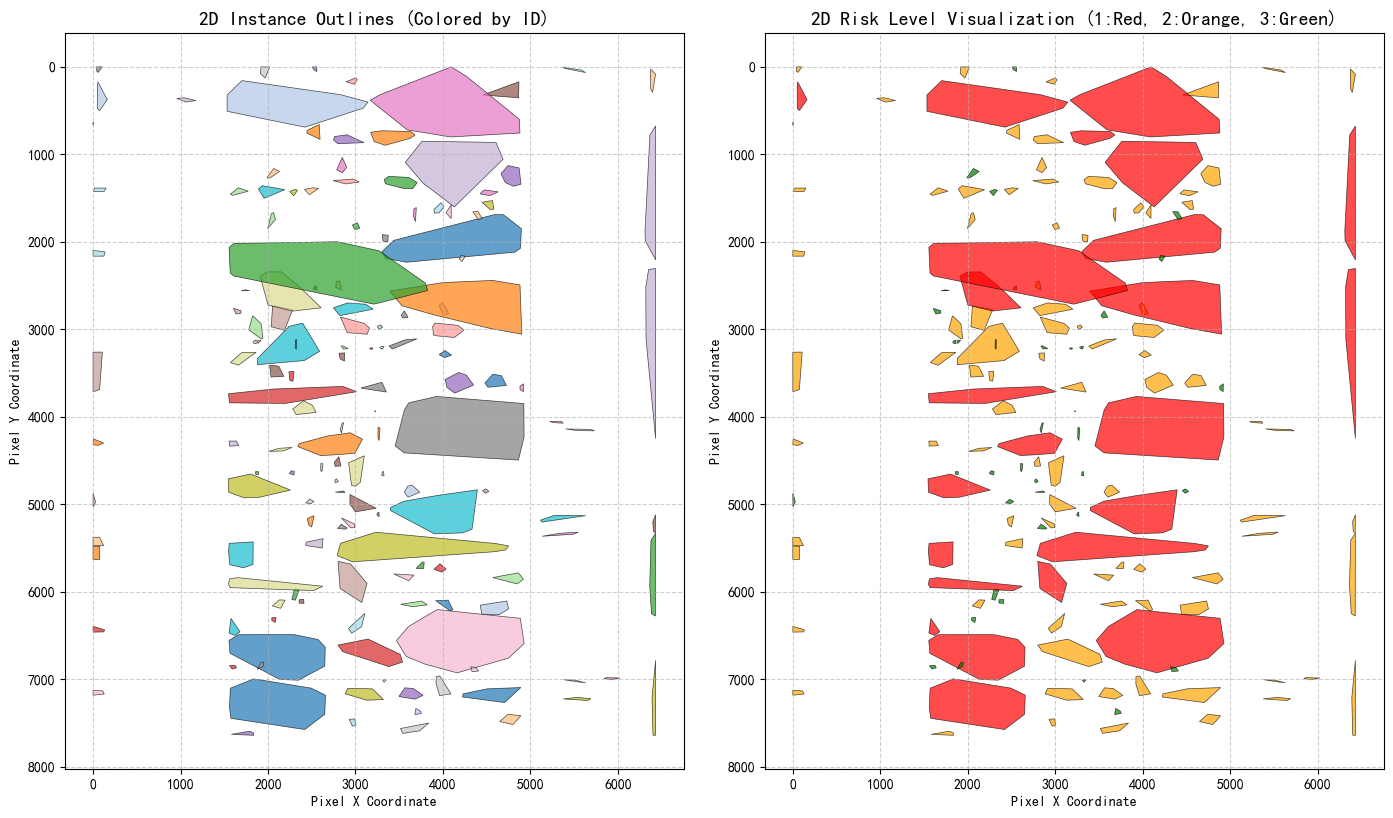

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np

# ====================================================
# 1. CONFIGURATION
# ====================================================
csv_path = "2d_point_info_convexhull.csv"

# Minimum number of points to form a valid polygon
MIN_POINTS_THRESHOLD = 3

# ====================================================
# 2. LOAD DATA
# ====================================================
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"❌ Error: CSV file not found at '{csv_path}'. Please check the path.")
    exit()

# Ensure correct data types and remove any invalid rows
df = df.dropna(subset=["x", "y"])
df[["x", "y"]] = df[["x", "y"]].astype(float)
df["instance_id"] = df["instance_id"].astype(int)
df["risk"] = df["risk"].astype(int)
print(f"✅ Loaded {len(df)} points from {csv_path}.")

# ====================================================
# 3. GROUP BY INSTANCE ID
# ====================================================
groups = df.groupby("instance_id")
print(f"✅ Found {len(groups)} unique instances.")

# ====================================================
# 4. PREPARE PLOT
# ====================================================
fig, (ax_inst, ax_risk) = plt.subplots(1, 2, figsize=(18, 9))

# Color maps
cmap = plt.colormaps.get("tab20")
risk_colors = {1: "red", 2: "orange", 3: "green"}

# ====================================================
# 5. DRAW FILLED POLYGONS
# ====================================================
drawn_count = 0
print(f"\nStarting to draw polygons. Instances with fewer than {MIN_POINTS_THRESHOLD} points will be skipped...")

for i, (instance_id, group) in enumerate(groups):
    if len(group) < MIN_POINTS_THRESHOLD:
        continue
    
    points = group[["x", "y"]].values

    # --- Left Plot: Instances colored by ID ---
    inst_color = cmap(i % cmap.N)
    poly_inst = MplPolygon(points, closed=True, facecolor=inst_color, edgecolor='k', alpha=0.7, linewidth=0.5)
    ax_inst.add_patch(poly_inst)

    # --- Right Plot: Instances colored by Risk ---
    risk_val = group["risk"].iloc[0]
    risk_color = risk_colors.get(risk_val, "gray")
    poly_risk = MplPolygon(points, closed=True, facecolor=risk_color, edgecolor='k', alpha=0.7, linewidth=0.5)
    ax_risk.add_patch(poly_risk)

    drawn_count += 1

print(f"✅ Drawing complete! Displayed {drawn_count} / {len(groups)} instances.")

# ====================================================
# 6. FINALIZE PLOT
# ====================================================
for ax in [ax_inst, ax_risk]:
    ax.set_aspect('equal')
    ax.autoscale()  # Auto-scale for patches
    ax.invert_yaxis()  # Image coordinates (0,0) at top-left
    ax.set_xlabel("Pixel X Coordinate")
    ax.set_ylabel("Pixel Y Coordinate")
    ax.grid(True, linestyle='--', alpha=0.6)

# Titles
ax_inst.set_title("2D Instance Outlines (Colored by ID)", fontsize=14)
ax_risk.set_title("2D Risk Level Visualization (1:Red, 2:Orange, 3:Green)", fontsize=14)

plt.tight_layout(rect=[0, 0.03, 0.8, 0.95])
plt.show()


In [15]:
import csv
import numpy as np
from PIL import Image

# ===================== CONFIGURATION =====================
input_csv = "2d_point_info_convexhull.csv"
output_csv = "3d_point_info.csv"
panoptic_img_path = "xxx_panoptic_seg.png"

# Tunnel parameters
r = 5.05       # Tunnel radius (meters)
s = 18.66      # Arc length along the tunnel cross-section (meters)
L = 20.0       # Tunnel length (meters)

# ===================== IMAGE DIMENSIONS =====================
img = Image.open(panoptic_img_path)
img_width, img_height = img.size

# Maximum angle of the arc (radians)
theta_max = s / r

# Offset to set the bottom of the tunnel at Z=0
Z_offset = r * np.cos(theta_max / 2)

print(f"Image width: {img_width}, height: {img_height}")
print(f"θ_max = {np.degrees(theta_max):.2f}°, Z_offset = {Z_offset:.3f} m")

# ===================== READ 2D CSV =====================
rows = []
with open(input_csv, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        rows.append(row)

# ===================== PROJECT TO 3D =====================
for row in rows:
    x_img = float(row["x"])
    y_img = float(row["y"])

    # --- Map horizontal pixel to arc length along cross-section ---
    s_i = (x_img / img_width) * s
    theta = s_i / r - theta_max / 2  # Left edge = -θ_max/2, right edge = +θ_max/2

    # --- Circular arc projection ---
    X = r * np.sin(theta) + r * np.sin(theta_max / 2)  # Translate so left edge X=0
    Z = r * np.cos(theta) - Z_offset                   # Bottom Z=0

    # --- Tunnel longitudinal direction ---
    Y = (y_img / img_height) * L

    # --- Update row values ---
    row["x"] = round(X, 2)
    row["y"] = round(Y, 2)
    row["z"] = round(Z, 2)

# ===================== WRITE 3D CSV =====================
fieldnames = list(rows[0].keys())
with open(output_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

print(f"✅ 3D projection CSV has been generated: {output_csv}")


Image width: 6432, height: 7642
θ_max = 211.71°, Z_offset = -1.380 m
✅ 3D projection CSV has been generated: 3d_point_info.csv


Image Width: 6432px
theta_max (deg): 211.71074
half_span (r*sin(theta/2)): 4.85787
Detection Mode: shifted (left=0)
Center ±1800px corresponds to raw X range: -4.33989 to 4.33989 m
Final X range for filtering (matching CSV coordinates): 0.51798 to 9.19776 m
Points after filtering: 591


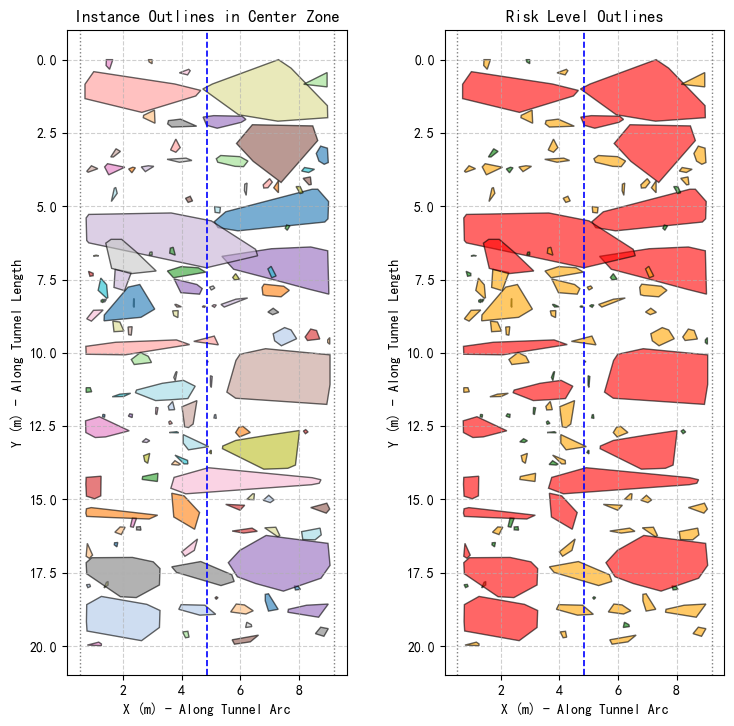

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np
import cv2

# ====================================================
# 1. Configuration
# ====================================================
csv_path = "3d_point_info.csv"
panoptic_img_path = "xxx_panoptic_seg.png"

# Tunnel geometry parameters
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
L = 20.0        # Tunnel length (m)
pix_range = 1800  # Pixel range from the center line for filtering

# ====================================================
# 2. Load CSV Data
# ====================================================
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: Could not find CSV file at '{csv_path}'. Please check the path.")
    exit()
    
df = df.dropna(subset=["x", "y"])
df[["x", "y"]] = df[["x", "y"]].astype(float)
df["instance_id"] = df["instance_id"].astype(str)
df["risk"] = df["risk"].astype(int)

# ====================================================
# 3. Read Image to get Dimensions
# ====================================================
img = cv2.imread(panoptic_img_path)
if img is None:
    print(f"Error: Could not read image file at '{panoptic_img_path}'. Please check the path.")
    exit()
height_img, width_img = img.shape[:2]
print(f"Image Width: {width_img}px")

# ====================================================
# 4. Calculate Arc Angle and Projection Range
# ====================================================
theta_max = s / r
half_span = r * np.sin(theta_max / 2)
print(f"theta_max (deg): {np.degrees(theta_max):.5f}")
print(f"half_span (r*sin(theta/2)): {half_span:.5f}")

# ====================================================
# 5. Calculate X-coordinate Range for Filtering
# ====================================================
# This section calculates the 3D 'x' coordinate range that corresponds to the
# central `pix_range` of the 2D unfolded image.
shift = half_span  # The amount to shift coordinates so the left edge is at X=0

# a. Calculate the angle from the center to the pixel boundary
theta_at_range = (pix_range / width_img) * theta_max

# b. Project this angle onto the horizontal x-axis to get the "raw" coordinate range
X_right_raw = r * np.sin(theta_at_range)
X_left_raw = -X_right_raw

# c. Shift the raw coordinates to match the CSV's coordinate system
X_filter_min = X_left_raw + shift
X_filter_max = X_right_raw + shift
coord_mode = "shifted (left=0)"

print(f"Detection Mode: {coord_mode}")
print(f"Center ±{pix_range}px corresponds to raw X range: {X_left_raw:.5f} to {X_right_raw:.5f} m")
print(f"Final X range for filtering (matching CSV coordinates): {X_filter_min:.5f} to {X_filter_max:.5f} m")

# ====================================================
# 6. Filter DataFrame by X-range
# ====================================================
df = df[(df["x"] >= X_filter_min) & (df["x"] <= X_filter_max)]
print(f"Points after filtering: {len(df)}")

# ====================================================
# 7. Group by Instance ID
# ====================================================
groups = df.groupby("instance_id")

# Color mapping
cmap = plt.colormaps.get("tab20")
num_groups = len(groups)
risk_colors = {1: "red", 2: "orange", 3: "green"}

# ====================================================
# 8. Create Plots
# ====================================================
fig, (ax_inst, ax_risk) = plt.subplots(1, 2, figsize=(18, 8))

for i, (name, group) in enumerate(groups):
    points = group[["x", "y"]].values
    
    # Ensure the polygon is closed for correct filling
    if len(points) >= 3:
        if not np.array_equal(points[0], points[-1]):
            points = np.vstack([points, points[0]])

        # Left Plot: Instance outlines
        poly_inst = MplPolygon(points, closed=True, facecolor=cmap(i % cmap.N),
                               edgecolor='black', alpha=0.6)
        ax_inst.add_patch(poly_inst)

        # Right Plot: Risk outlines
        risk_val = group["risk"].iloc[0]
        poly_risk = MplPolygon(points, closed=True, facecolor=risk_colors.get(risk_val, "gray"),
                               edgecolor='black', alpha=0.6)
        ax_risk.add_patch(poly_risk)

# ====================================================
# 9. Draw Helper Lines and Set Plot Properties
# ====================================================
for ax in [ax_inst, ax_risk]:
    ax.axvline(x=shift, color='blue', linestyle='--', lw=1.2, label="Tunnel Center Line")
    ax.axvline(x=X_filter_min, color='gray', linestyle=':', lw=1, label=f'Boundary ({X_filter_min:.2f}m)')
    ax.axvline(x=X_filter_max, color='gray', linestyle=':', lw=1, label=f'Boundary ({X_filter_max:.2f}m)')

    ax.set_aspect('equal')
    ax.autoscale()
    ax.set_xlabel("X (m) - Along Tunnel Arc")
    ax.set_ylabel("Y (m) - Along Tunnel Length")
    ax.invert_yaxis()
    # ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

ax_inst.set_title(f"Instance Outlines in Center Zone")
ax_risk.set_title("Risk Level Outlines")

# plt.suptitle("3D Point Cloud Projection Analysis of Tunnel Defects", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.6, 0.95])
plt.show()

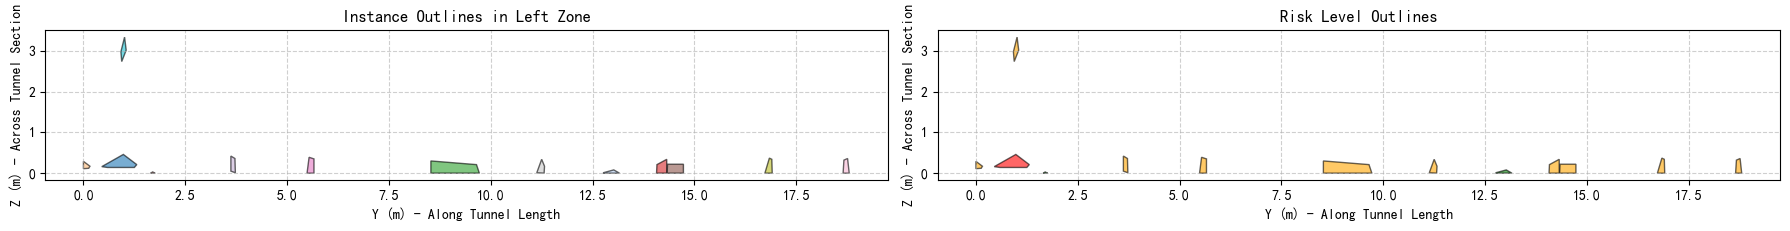

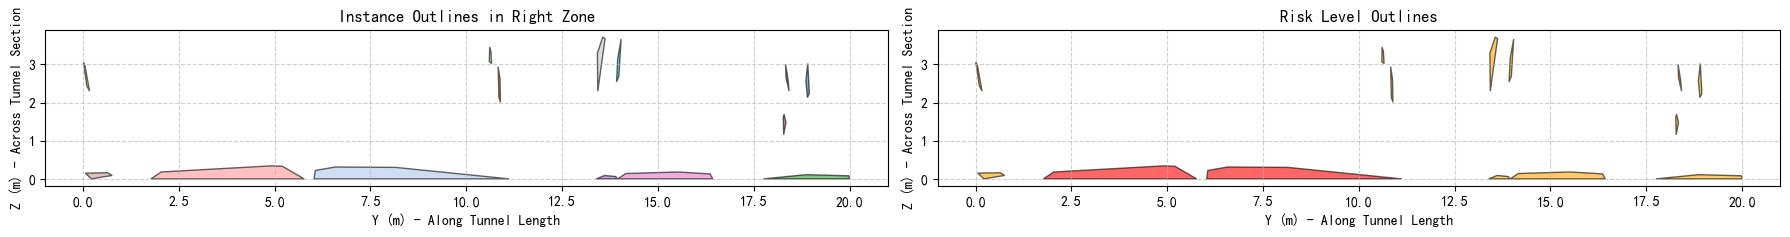

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np
import cv2

# ====================================================
# 1. Configuration
# ====================================================
csv_path = "3d_point_info.csv"
panoptic_img_path = "xxx_panoptic_seg.png"

# Tunnel geometry parameters
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
L = 20.0        # Tunnel length (m)
pix_range = 1800  # Pixel range from the center line to define boundaries

# ====================================================
# 2. Load CSV and verify 'z' coordinate exists
# ====================================================
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: Could not find CSV file at '{csv_path}'. Please check the path.")
    exit()

if 'z' not in df.columns:
    print(f"Error: CSV file '{csv_path}' is missing the 'z' coordinate column, which is required for Y-Z plane visualization.")
    exit()

df = df.dropna(subset=["x", "y", "z"])
df[["x", "y", "z"]] = df[["x", "y", "z"]].astype(float)
df["instance_id"] = df["instance_id"].astype(str)
df["risk"] = df["risk"].astype(int)

# ====================================================
# 3. Calculate coordinate boundaries for the central zone
# ====================================================
img = cv2.imread(panoptic_img_path)
if img is None:
    print(f"Error: Could not read image file at '{panoptic_img_path}'.")
    exit()
height_img, width_img = img.shape[:2]

theta_max = s / r
half_span = r * np.sin(theta_max / 2)
theta_at_range = (pix_range / width_img) * theta_max
X_right_raw = r * np.sin(theta_at_range)
X_left_raw = -X_right_raw
shift = half_span
X_filter_min = X_left_raw + shift
X_filter_max = X_right_raw + shift

# print(f"Defining boundary zones using X-range: < {X_filter_min:.5f} m and > {X_filter_max:.5f} m")

# ====================================================
# 4. Separate the data into left and right DataFrames
# ====================================================
df_left = df[df["x"] < X_filter_min]
df_right = df[df["x"] > X_filter_max]

# print(f"\nFound {df_left['instance_id'].nunique()} unique instances in the Left Zone.")
# print(f"Found {df_right['instance_id'].nunique()} unique instances in the Right Zone.")

# ====================================================
# 5. Define a reusable plotting function
# ====================================================
def plot_zone_on_yz_plane(dataframe, zone_name):
    """
    Takes a DataFrame and a zone name, then generates two Y-Z plane projection plots.
    """
    if dataframe.empty:
        print(f"\nNo instances found in the {zone_name}. Skipping plot.")
        return

    # print(f"\nGenerating visualization for {zone_name}...")
    
    groups = dataframe.groupby("instance_id")
    
    # Color mapping
    cmap = plt.colormaps.get("tab20")
    num_groups = len(groups)
    colors_inst = [cmap(i / num_groups) for i in range(num_groups)] if num_groups > 0 else []
    risk_colors = {1: "red", 2: "orange", 3: "green"}
    
    # Create figure
    fig, (ax_inst, ax_risk) = plt.subplots(1, 2, figsize=(18, 8))
    # fig.suptitle(f"Y-Z Plane Projection of Instances in the {zone_name}", fontsize=16)

    for i, (name, group) in enumerate(groups):
        # Use Y and Z coordinates for the projection
        points = group[["y", "z"]].values
        
        if len(points) >= 3:
            if not np.array_equal(points[0], points[-1]):
                points = np.vstack([points, points[0]])

            # Left plot: Instance outlines
            poly_inst = MplPolygon(points, closed=True, facecolor=colors_inst[i],
                                   edgecolor='black', alpha=0.6)
            ax_inst.add_patch(poly_inst)

            # Right plot: Risk outlines
            risk_val = group["risk"].iloc[0]
            poly_risk = MplPolygon(points, closed=True, facecolor=risk_colors.get(risk_val, "gray"),
                                   edgecolor='black', alpha=0.6)
            ax_risk.add_patch(poly_risk)

    # Set plot properties
    for ax in [ax_inst, ax_risk]:
        ax.set_aspect('equal')
        ax.autoscale()
        ax.set_xlabel("Y (m) - Along Tunnel Length")
        ax.set_ylabel("Z (m) - Across Tunnel Section")
        ax.grid(True, linestyle='--', alpha=0.6)

    ax_inst.set_title(f"Instance Outlines in {zone_name}")
    ax_risk.set_title("Risk Level Outlines")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ====================================================
# 6. Call the plotting function to generate the two sets of plots
# ====================================================
# First plot set: Left zone instances
plot_zone_on_yz_plane(df_left, "Left Zone")

# Second plot set: Right zone instances
plot_zone_on_yz_plane(df_right, "Right Zone")

In [21]:
# for testing
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

# ====================================================
# 1. File Paths
# ====================================================
input_csv_path = "3d_point_info.csv"
panoptic_img_path = "xxx_panoptic_seg.png"

# Output CSV filenames
output_center_csv = "3d_point_info_c.csv"
output_left_csv = "3d_point_info_l.csv"
output_right_csv = "3d_point_info_r.csv"

# ====================================================
# 2. Tunnel Geometry Parameters
# ====================================================
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
pix_range = 1800  # Pixel range from centerline

# ====================================================
# 3. Load and Preprocess Data
# ====================================================
print(f"Loading data from '{input_csv_path}'...")
try:
    df = pd.read_csv(input_csv_path)
except FileNotFoundError:
    print(f"Error: Could not find CSV file '{input_csv_path}'. Please check the path.")
    exit()

# --- Data Cleaning ---
# Ensure all required columns exist and drop rows with missing values
df = df.dropna(subset=["x", "y", "instance_id", "risk", "category_name", "area_m2"])

# Explicitly set correct data types
df[["x", "y", "area"]] = df[["x", "y", "area_m2"]].astype(float)
df["instance_id"] = df["instance_id"].astype(int)
df["risk"] = df["risk"].astype(int)
df["category_name"] = df["category_name"].astype(str)

print(f"Data loaded: {len(df)} points, {df['instance_id'].nunique()} unique instances.")

# ====================================================
# 4. Calculate Center Region X Boundaries
# ====================================================
print("Calculating center region X boundaries...")
img = cv2.imread(panoptic_img_path)
if img is None:
    print(f"Error: Could not read image file '{panoptic_img_path}'.")
    exit()
height_img, width_img = img.shape[:2]

theta_max = s / r
half_span = r * np.sin(theta_max / 2)

# Calculate angle corresponding to pixel range
theta_at_range = (pix_range / width_img) * theta_max
X_right_raw = r * np.sin(theta_at_range)
X_left_raw = -X_right_raw

# Shift to match CSV coordinate system
shift = half_span
X_filter_min = X_left_raw + shift
X_filter_max = X_right_raw + shift

print(f"Image width: {width_img} px")
print(f"Calculated center X range (shifted coordinates): {X_filter_min:.5f} m to {X_filter_max:.5f} m")

# ====================================================
# 5. Divide Instances into Three Regions (Left, Center, Right)
# ====================================================
print("Dividing instances based on position...")

groups = df.groupby("instance_id")

center_ids = []
left_ids = []
right_ids = []

# Use tqdm to show progress
for instance_id, group in tqdm(groups, desc="Assigning Instances"):
    x_min_instance = group['x'].min()
    x_max_instance = group['x'].max()
    
    # Core logic:
    # If any part of the instance overlaps the center region, it belongs to center
    if x_max_instance >= X_filter_min and x_min_instance <= X_filter_max:
        center_ids.append(instance_id)
    # Instance fully left of center region
    elif x_max_instance < X_filter_min:
        left_ids.append(instance_id)
    # Instance fully right of center region
    elif x_min_instance > X_filter_max:
        right_ids.append(instance_id)

print("\nInstance assignment completed:")
print(f"  - Center region: {len(center_ids)} instances")
print(f"  - Left region: {len(left_ids)} instances")
print(f"  - Right region: {len(right_ids)} instances")

# ====================================================
# 6. Generate and Save Three CSV Files
# ====================================================
print("\nGenerating and saving output files...")

# --- Center region ---
if center_ids:
    df_center = df[df['instance_id'].isin(center_ids)]
    df_center.to_csv(output_center_csv, index=False)
    print(f"✅ Center region CSV '{output_center_csv}' saved with {len(df_center)} points.")
else:
    print(f"ℹ️ No instances in center region. File '{output_center_csv}' not created.")

# --- Left region ---
if left_ids:
    df_left = df[df['instance_id'].isin(left_ids)]
    df_left.to_csv(output_left_csv, index=False)
    print(f"✅ Left region CSV '{output_left_csv}' saved with {len(df_left)} points.")
else:
    print(f"ℹ️ No instances in left region. File '{output_left_csv}' not created.")

# --- Right region ---
if right_ids:
    df_right = df[df['instance_id'].isin(right_ids)]
    df_right.to_csv(output_right_csv, index=False)
    print(f"✅ Right region CSV '{output_right_csv}' saved with {len(df_right)} points.")
else:
    print(f"ℹ️ No instances in right region. File '{output_right_csv}' not created.")


Loading data from '3d_point_info.csv'...
Data loaded: 702 points, 151 unique instances.
Calculating center region X boundaries...
Image width: 6432 px
Calculated center X range (shifted coordinates): 0.51798 m to 9.19776 m
Dividing instances based on position...


Assigning Instances:   0%|          | 0/151 [00:00<?, ?it/s]


Instance assignment completed:
  - Center region: 124 instances
  - Left region: 13 instances
  - Right region: 14 instances

Generating and saving output files...
✅ Center region CSV '3d_point_info_c.csv' saved with 591 points.
✅ Left region CSV '3d_point_info_l.csv' saved with 52 points.
✅ Right region CSV '3d_point_info_r.csv' saved with 59 points.


In [23]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm  # For progress bars

# ====================================================
# 1. File Paths
# ====================================================
input_csv_path = "3d_point_info.csv"
panoptic_img_path = "xxx_panoptic_seg.png"

# Output CSV with zones
output_csv_with_zones = "3d_point_info_with_zones.csv"

# ====================================================
# 2. Tunnel Geometry Parameters
# ====================================================
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
pix_range = 1800  # Pixel range from centerline

# ====================================================
# 3. Load and Preprocess Data
# ====================================================
print(f"Loading data from '{input_csv_path}'...")
try:
    df = pd.read_csv(input_csv_path)
except FileNotFoundError:
    print(f"Error: Could not find CSV file '{input_csv_path}'. Please check the path.")
    exit()

# Basic data cleaning
df = df.dropna(subset=["x", "y", "instance_id", "risk", "category_name", "area_m2"])

# Explicitly set correct data types
df[["x", "y", "area"]] = df[["x", "y", "area_m2"]].astype(float)
df["instance_id"] = df["instance_id"].astype(int)
df["risk"] = df["risk"].astype(int)
df["category_name"] = df["category_name"].astype(str)

print(f"Data loaded: {len(df)} points, {df['instance_id'].nunique()} unique instances.")

# ====================================================
# 4. Calculate Center Region X Boundaries
# ====================================================
print("Calculating center region X boundaries...")
img = cv2.imread(panoptic_img_path)
if img is None:
    print(f"Error: Could not read image file '{panoptic_img_path}' to get width.")
    exit()
height_img, width_img = img.shape[:2]

theta_max = s / r
half_span = r * np.sin(theta_max / 2)

theta_at_range = (pix_range / width_img) * theta_max
X_right_raw = r * np.sin(theta_at_range)
X_left_raw = -X_right_raw

shift = half_span
X_filter_min = X_left_raw + shift
X_filter_max = X_right_raw + shift

print(f"Image width: {width_img} px")
print(f"Calculated center X range (shifted coordinates): {X_filter_min:.5f} m to {X_filter_max:.5f} m")

# ====================================================
# 5. Assign Instances to Zones
# ====================================================
print("Assigning instances to zones...")

groups = df.groupby("instance_id")

# Create a mapping from instance_id to zone
zone_map = {}

for instance_id, group in tqdm(groups, desc="Assigning Instances"):
    x_min_instance = group['x'].min()
    x_max_instance = group['x'].max()
    
    # Core logic
    if x_max_instance >= X_filter_min and x_min_instance <= X_filter_max:
        zone_map[instance_id] = 'c'  # Center
    elif x_max_instance < X_filter_min:
        zone_map[instance_id] = 'l'  # Left
    elif x_min_instance > X_filter_max:
        zone_map[instance_id] = 'r'  # Right

# Print statistics
zone_counts = pd.Series(zone_map).value_counts()
print("\nInstance assignment completed:")
print(f"  - Center zone ('c') instances: {zone_counts.get('c', 0)}")
print(f"  - Left zone ('l') instances: {zone_counts.get('l', 0)}")
print(f"  - Right zone ('r') instances: {zone_counts.get('r', 0)}")

# ====================================================
# 6. Add 'zone' column and save single CSV
# ====================================================
print("\nAdding 'zone' column and saving output file...")

# Map zone information to new column
df['zone'] = df['instance_id'].map(zone_map)

# Save the full DataFrame with 'zone' column
df.to_csv(output_csv_with_zones, index=False)
print(f"✅ File '{output_csv_with_zones}' with zone information ('zone' column) saved successfully.")


Loading data from '3d_point_info.csv'...
Data loaded: 702 points, 151 unique instances.
Calculating center region X boundaries...
Image width: 6432 px
Calculated center X range (shifted coordinates): 0.51798 m to 9.19776 m
Assigning instances to zones...


Assigning Instances: 100%|██████████| 151/151 [00:00<00:00, 6979.57it/s]


Instance assignment completed:
  - Center zone ('c') instances: 124
  - Left zone ('l') instances: 13
  - Right zone ('r') instances: 14

Adding 'zone' column and saving output file...
✅ File '3d_point_info_with_zones.csv' with zone information ('zone' column) saved successfully.
